# Lab Report
*Jakub Skalski, 314007*

In [1]:
identity = function(x) x

mse = function(x, y) mean((x-y)^2)

bias = function(x, y) mean(x-y)

measure = function(estimations, truth) {
	c(
		mean 		= mean(estimations),
		MSE 		= mse(truth, estimations),
		bias 		= bias(truth, estimations),
		variance	= var(estimations)
	)
}

estimate = function(estimator, distribution, ..., quantity = identity, n = 50, times = 1e4) {
	truth = list(...)[[1]]
	estimations = numeric(times)
	for (i in 1:times) {
		sample = distribution(n, ...)
		estimations[i] = quantity(estimator(sample))
	}
	return(measure(estimations, quantity(truth)))
}

compare = function(..., variables = list()) {
	metric = function (vs) do.call(estimate, append(unlist(vs), list(...)))
	metrics = mapply(metric, variables)
	data.frame(unlist(metrics))
}

series = function(..., range = 20:100, by = "n") {
	namedpair = function(value) {
		pair = c(value)
		names(pair) = by
		return(pair)
	}

	df = compare(..., variables = lapply(range, namedpair))
	colnames(df) = range
	return(df)
}

series.plot.single = function(..., metric = "MSE") {
	data = list(...)
	colors = rainbow(length(data))
	sample = as.numeric(colnames(data[[1]]))

	plot(sample, data[[1]][metric,], ylab = "", xlab = "", type="n")
	for (i in 1:length(data)) lines(sample, data[[i]][metric,], col=colors[i])

	title(metric, line = 1)
	legend(
		"topright", col = colors, lwd = 2,
		legend = as.character(substitute(list(...)))[-1]
	)
}

series.plot = function(..., metrics = list("MSE", "variance", "bias")) {
	par(mfrow = c(1, length(metrics)))
	options(repr.plot.width=18, repr.plot.height=6)
	for (m in metrics) series.plot.single(..., metric = m)
}

## Exercise 1

In [2]:
mean.div.5 = function(sample) mean(sample)/5

at.least.three = function(p) {
	dbinom(3, 5, p) +
	dbinom(4, 5, p) +
	dbinom(5, 5, p)
}

rbinom.p = list(
	a = c(p=0.1),
	b = c(p=0.3),
	c = c(p=0.5),
	d = c(p=0.7),
	e = c(p=0.9)
)

In [3]:
print(compare(
	distribution = rbinom,
	estimator = mean.div.5,
	quantity = at.least.three,
	variables = rbinom.p,
	size = 5, n = 50
))

                     a            b            c           d            e
mean      9.362354e-03  0.164701818 4.999302e-01 0.834767941 9.907833e-01
MSE       2.462663e-05  0.001457470 3.546829e-03 0.001463164 2.472392e-05
bias     -8.023541e-04 -0.001621818 6.984449e-05 0.002152059 6.566766e-04
variance  2.398525e-05  0.001454986 3.547179e-03 0.001458678 2.429512e-05


MSE is highest for p=0.5 (since it introduces the largest variance) and drops the more we deviate from that point.

## Exercise 2

In [12]:
poisson.set.of.ten = function(lambda) sum(mapply(function(x) dpois(x, lambda), 0:10))

poisson.density = function(x) function(lambda) dpois(x, lambda)

X = 1:10; vars = lapply(X, function(x) c(quantity=poisson.density(x)))

In [21]:
ex2 = function(n) {
	a = compare(
		distribution = rpois,
		estimator = mean,
		variables = vars,
		lambda = 0.5
	); colnames(a) = X

	b = compare(
		distribution = rpois,
		estimator = mean,
		variables = vars,
		lambda = 1.0
	); colnames(b) = X


	c = compare(
		distribution = rpois,
		estimator = mean,
		variables = vars,
		lambda = 2.0
	); colnames(c) = X


	d = compare(
		distribution = rpois,
		estimator = mean,
		variables = vars,
		lambda = 5.0
	); colnames(d) = X

	series.plot(a, b, c, d, metrics=list("mean", "MSE", "variance", "bias"))
}

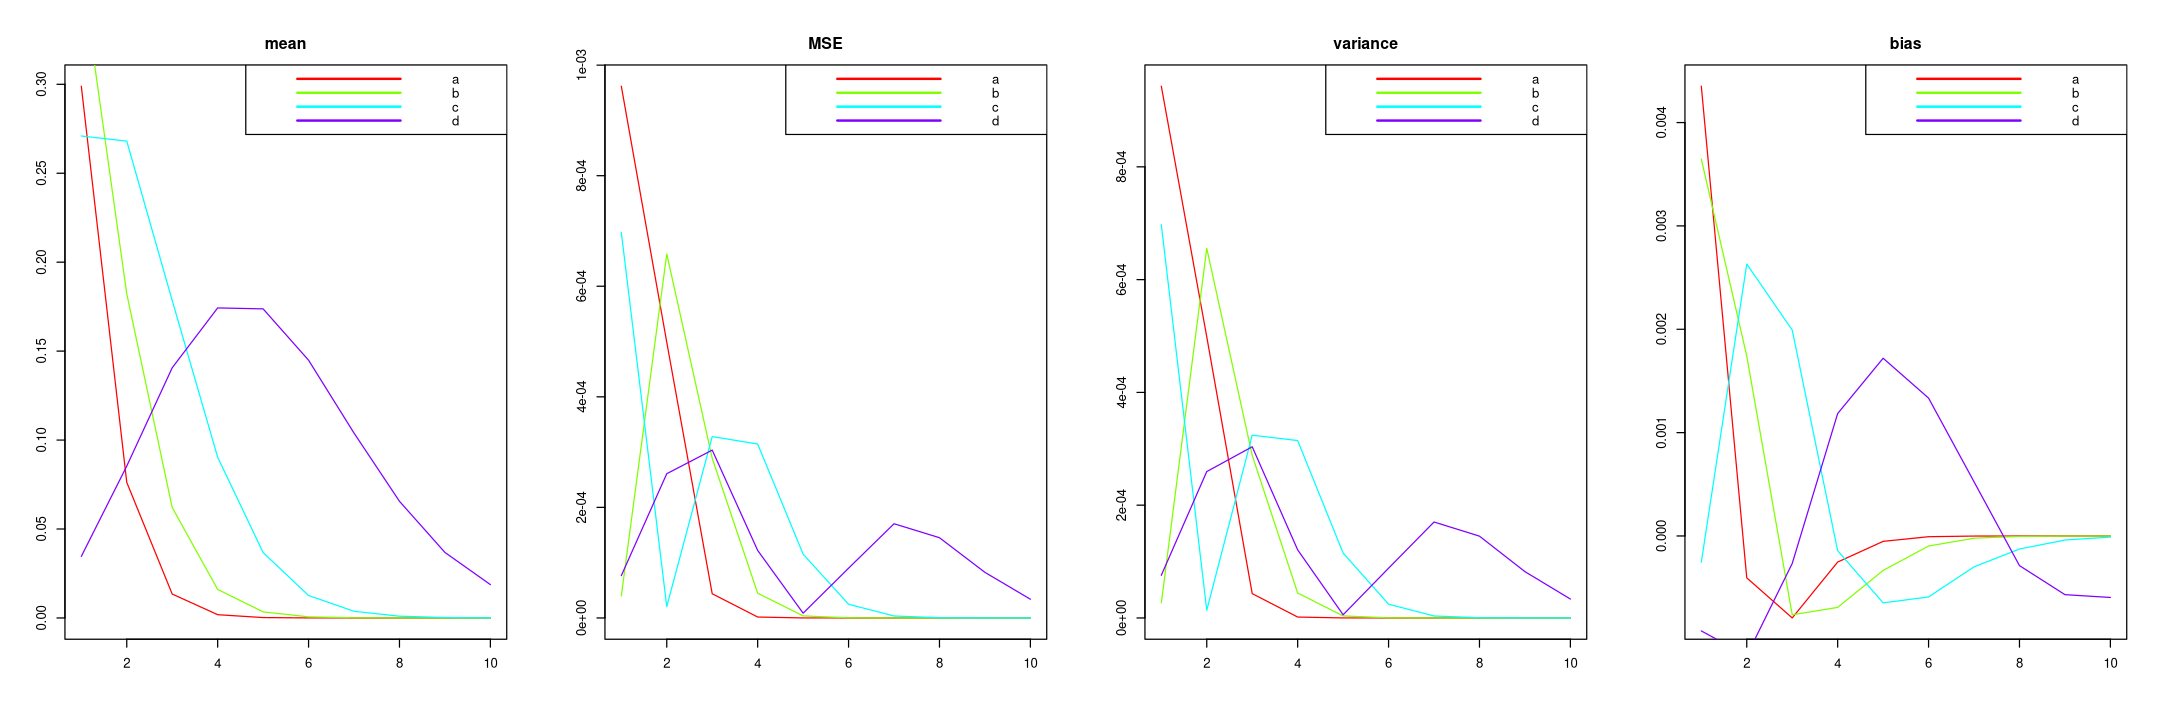

In [23]:
ex2(n = 50)

## Exercise 3

In [7]:
beta.mle = function(sample) -length(sample)/sum(log(sample))

fisher.information = function(θ) 1/θ^2

y = function(sample, θ) {
	𝛳 = beta.mle(sample)
	sqrt(length(sample) * fisher.information(𝛳)) * (𝛳 - θ)
}

In [8]:
estimate.y = function(θ, n = 50, times = 1e4) {
	estimations = numeric(times)
	for (i in 1:times) {
		sample = rbeta(n, θ, 1)
		estimations[i] = y(sample, θ)
	}
	return(estimations)
}

make.plots = function(sample) {
	par(mfrow = c(1, 2))
	options(repr.plot.width=18, repr.plot.height=6)

	hist(sample, density=20, breaks=200, prob=TRUE, xlim=c(-3, 3), ylim=c(0, 0.5), main="Histogram")
	curve(dnorm(x, mean=mean(sample), sd=sqrt(var(sample))), col="darkred", lwd=3, add=TRUE)

	qqnorm(sample, col = rgb(red = 0, green = 0, blue = 0, alpha = 0.1))
	qqline(sample, col="darkred", lwd=3)
}

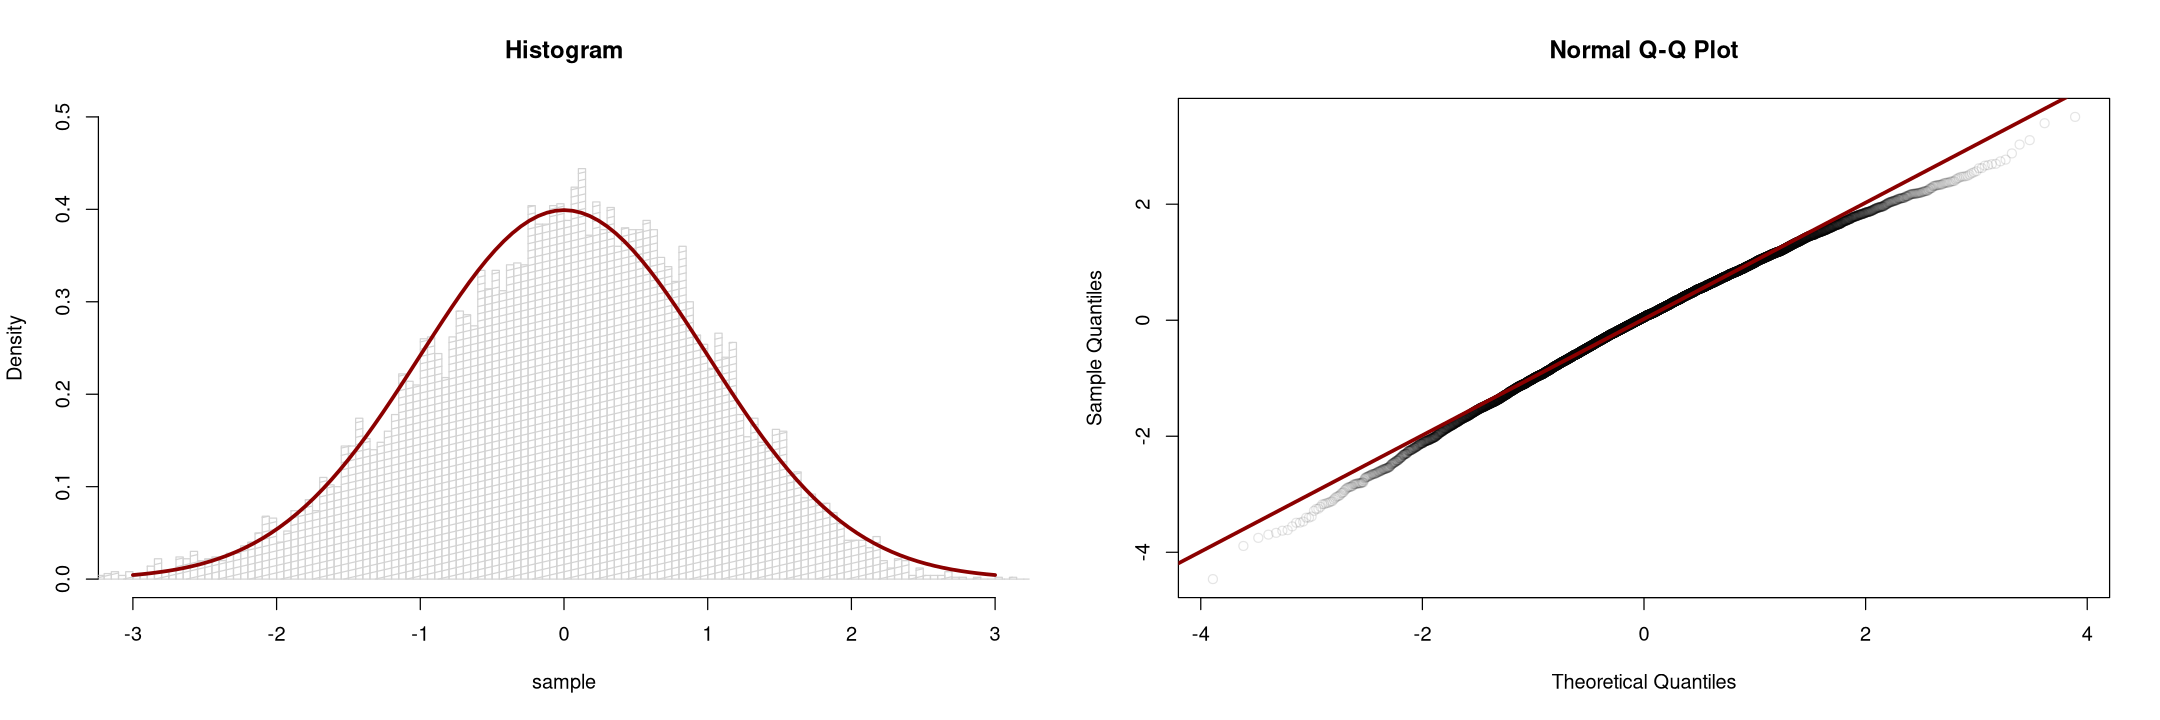

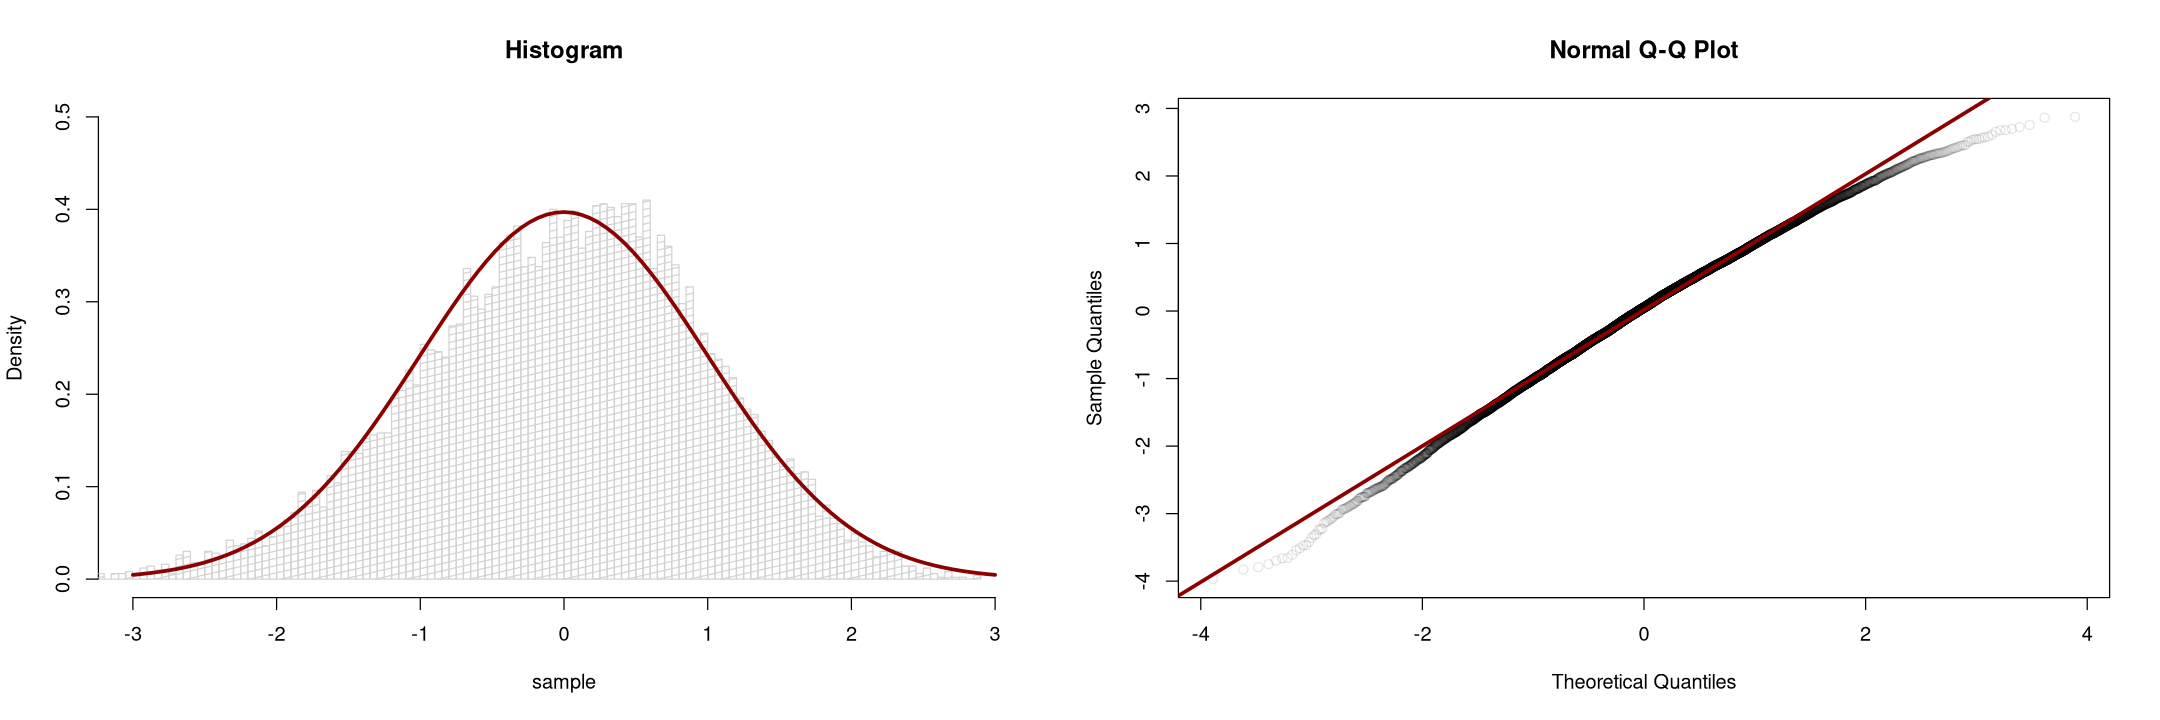

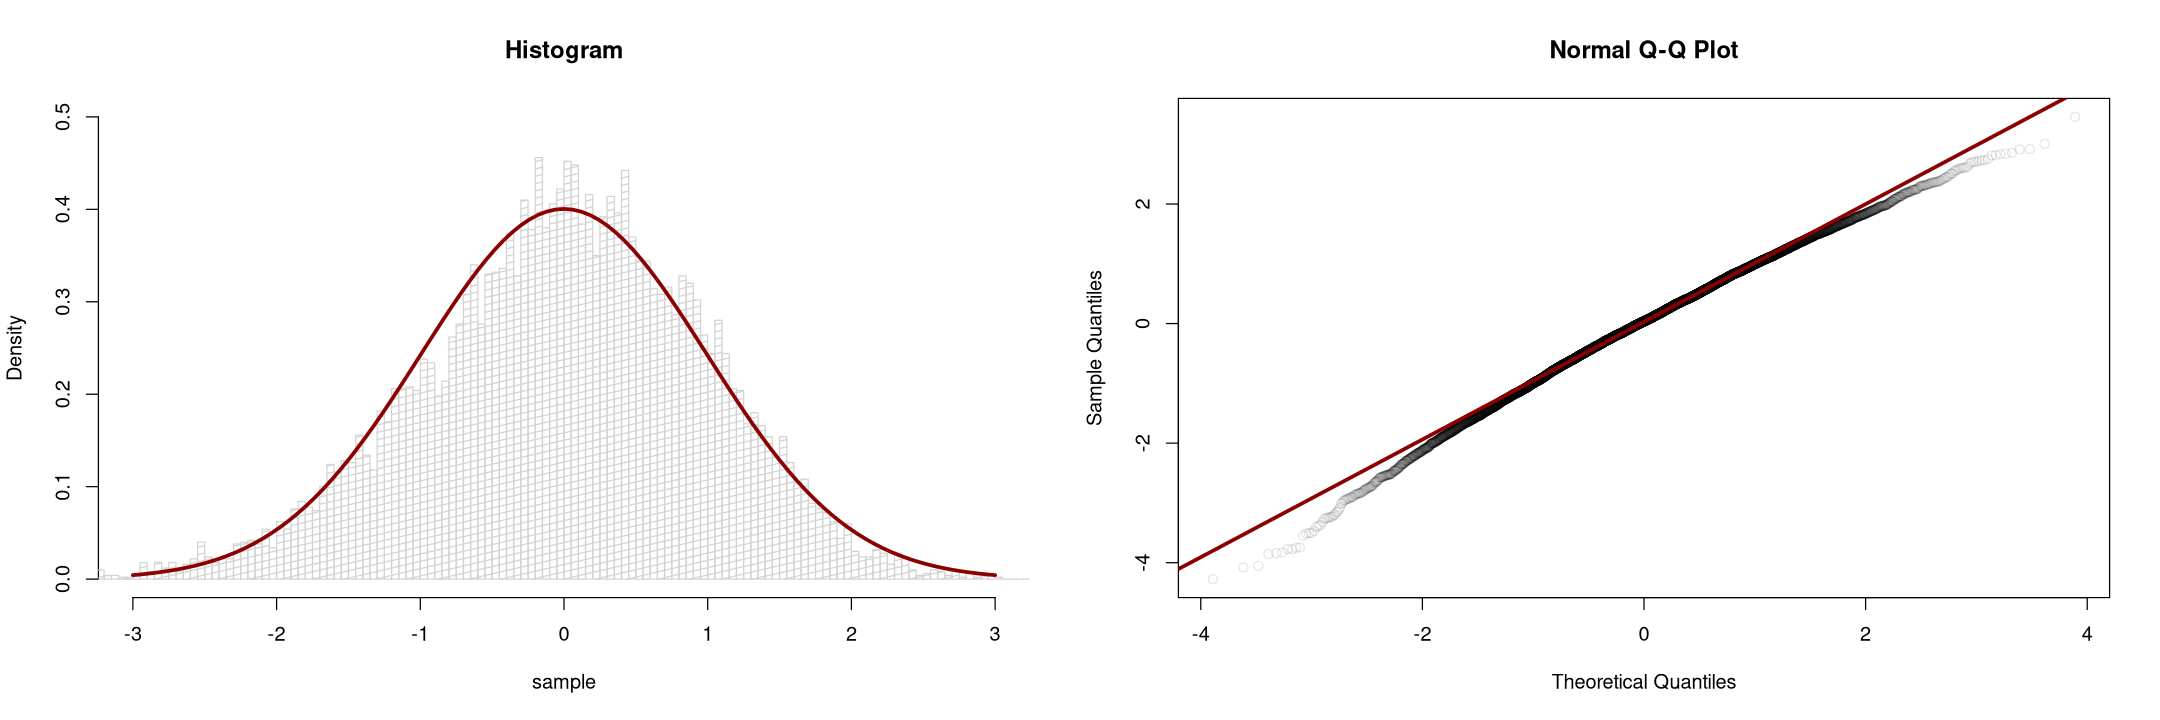

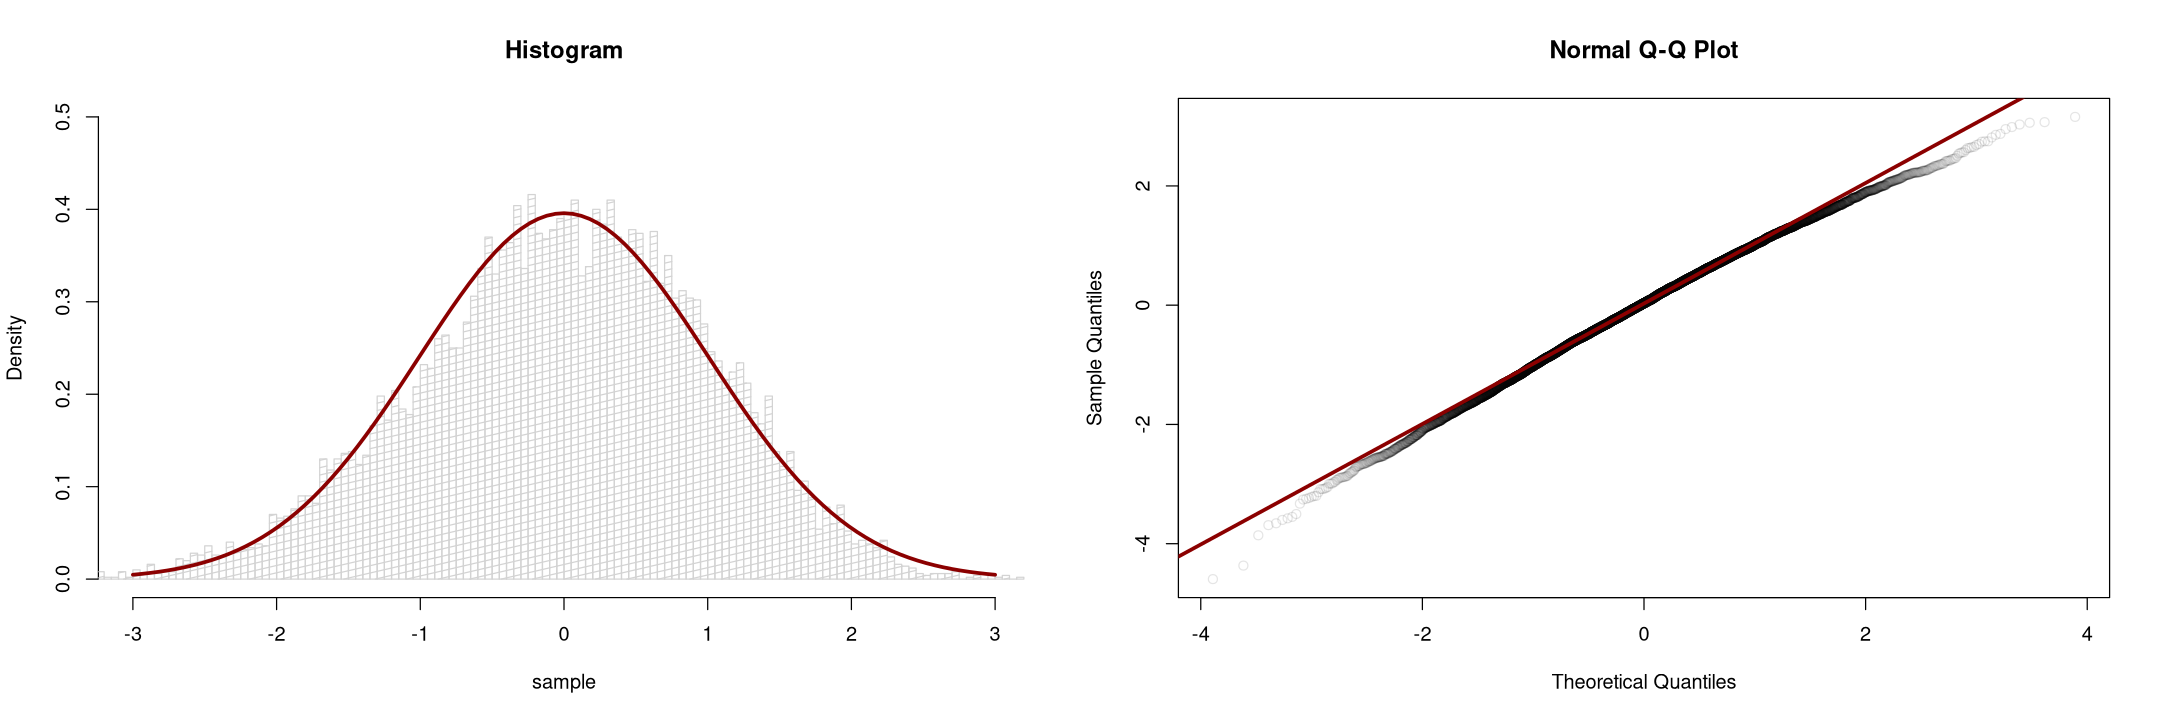

In [9]:
make.plots(estimate.y(θ = 0.5))
make.plots(estimate.y(θ = 1.0))
make.plots(estimate.y(θ = 2.0))
make.plots(estimate.y(θ = 5.0))

Distribution looks aproximately normal but whith a slight right skew that seems to disappear with larger thetas.

# Exercise 4

#### Mean

In [247]:
print(compare(
	distribution = rlaplace,
	estimator = mean,
	variables = list(
		a = c(m = 1, s = 1),
		b = c(m = 4, s = 1),
		c = c(m = 1, s = 2)
	)
))

                    a            b            c
mean     0.9993123135 3.9993377933  1.005942984
MSE      0.0402459408 0.0403309607  0.160095016
bias     0.0006876865 0.0006622067 -0.005942984
variance 0.0402494928 0.0403345556  0.160075704


#### Median

In [248]:
print(compare(
	distribution = rlaplace,
	estimator = median,
	variables = list(
		a = c(m = 1, s = 1),
		b = c(m = 4, s = 1),
		c = c(m = 1, s = 2)
	)
))

                   a            b           c
mean     0.997007582  4.001146574 0.994818238
MSE      0.024353100  0.024426383 0.101193044
bias     0.002992418 -0.001146574 0.005181762
variance 0.024346580  0.024427511 0.101176311


#### Randomized weighted sum

In [249]:
probs = function(n) diff(c(0, sort(runif(n-1)), 1))
randomized_weight_sum = function(sample) sum(sample * probs(length(sample)))

In [250]:
print(compare(
	distribution = rlaplace,
	estimator = randomized_weight_sum,
	variables = list(
		a = c(m = 1, s = 1),
		b = c(m = 4, s = 1),
		c = c(m = 1, s = 2)
	)
))

                    a             b           c
mean      1.002420708  4.0006651682 0.998422383
MSE       0.080661395  0.0779786078 0.312464387
bias     -0.002420708 -0.0006651682 0.001577617
variance  0.080663601  0.0779859640 0.312493147


#### Specific weighted sum

In [253]:
w = function(i, n) {
	f = function(x) dnorm(qnorm(x/n))
	f(i - 1) - f(i)
}

wi_weight_sum = function(sample) {
	n = length(sample)
	sum(sort(sample) * mapply(w, 1:n, n))
}

In [254]:
print(compare(
	distribution = rlaplace,
	estimator = wi_weight_sum,
	variables = list(
		a = c(m = 1, s = 1),
		b = c(m = 4, s = 1),
		c = c(m = 1, s = 2)
	)
))

                   a          b          c
mean      1.33606546 1.33420003  2.6752132
MSE       0.15235346 7.14652075  2.9663048
bias     -0.33606546 2.66579997 -1.6752132
variance  0.03941741 0.04003526  0.1599817


Median is now the better estimator as opposed to the previously best mean.
This is what we would expect, since MLE for normal distribution is the mean while MLE for laplace is the median.

Apart from that only the results from the last estimator are noticeably different compared to the previous lab report but those were not a product of using a good estimator in the first place.

# Exercise 5

### ex.1

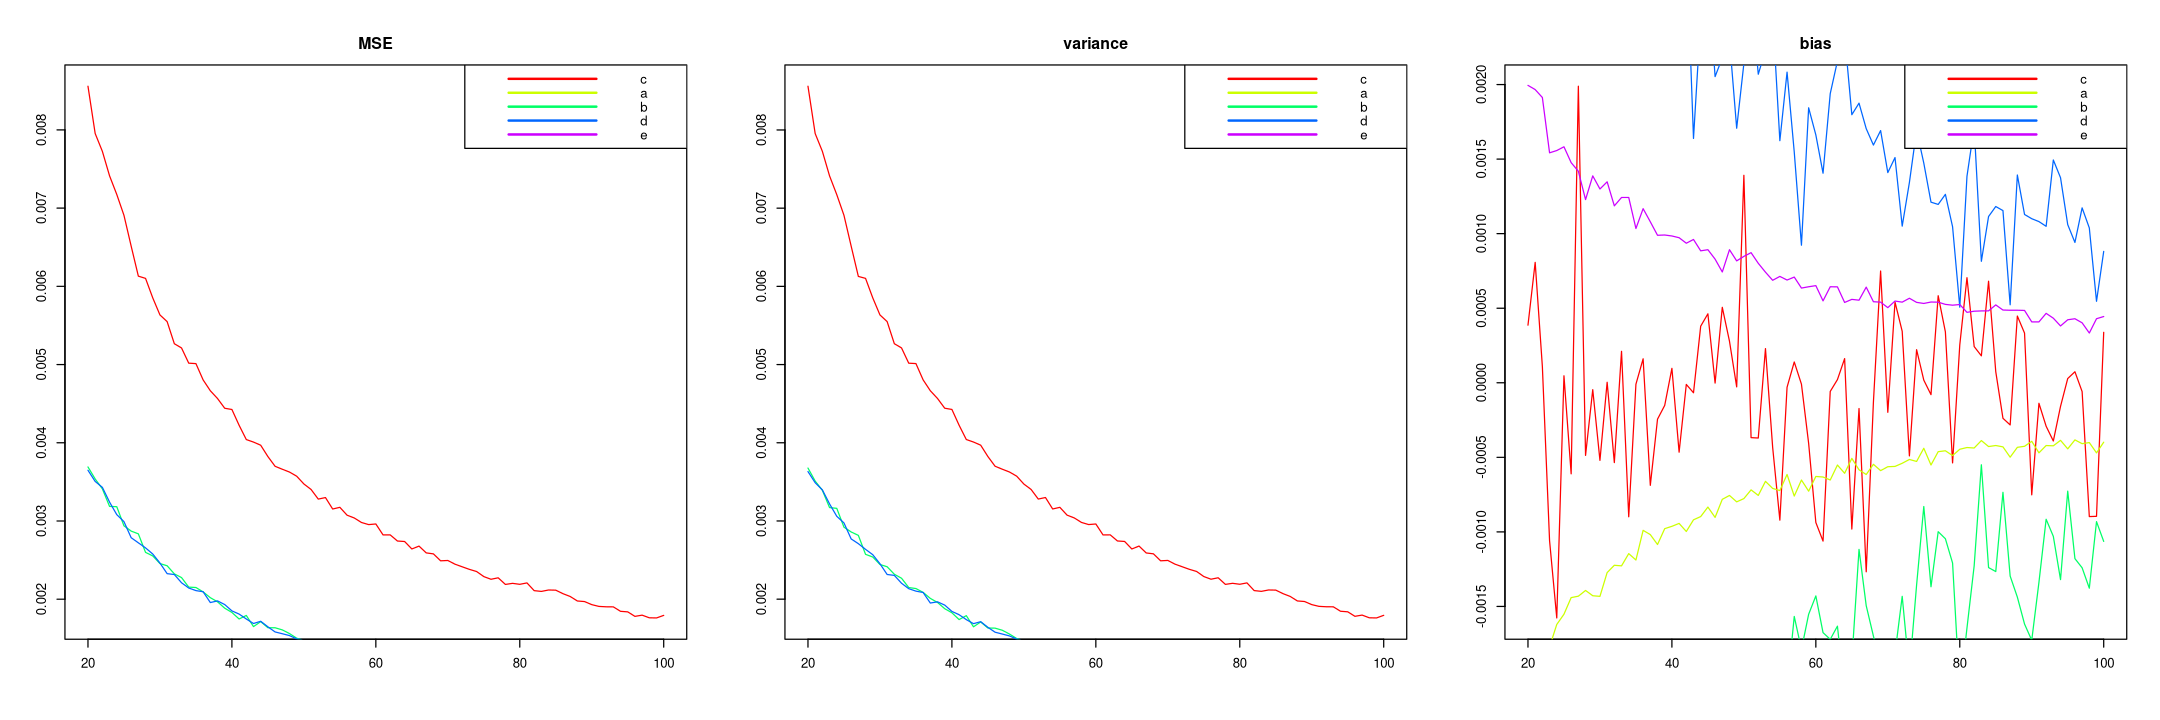

In [19]:
a = series(p = 0.1, distribution = rbinom, estimator = mean.div.5, quantity = at.least.three, size = 5)
b = series(p = 0.3, distribution = rbinom, estimator = mean.div.5, quantity = at.least.three, size = 5)
c = series(p = 0.5, distribution = rbinom, estimator = mean.div.5, quantity = at.least.three, size = 5)
d = series(p = 0.7, distribution = rbinom, estimator = mean.div.5, quantity = at.least.three, size = 5)
e = series(p = 0.9, distribution = rbinom, estimator = mean.div.5, quantity = at.least.three, size = 5)
series.plot(c, a, b, d, e)

Here we can observe that the skew of bias depends on the value of the parameter in question.

### ex.2

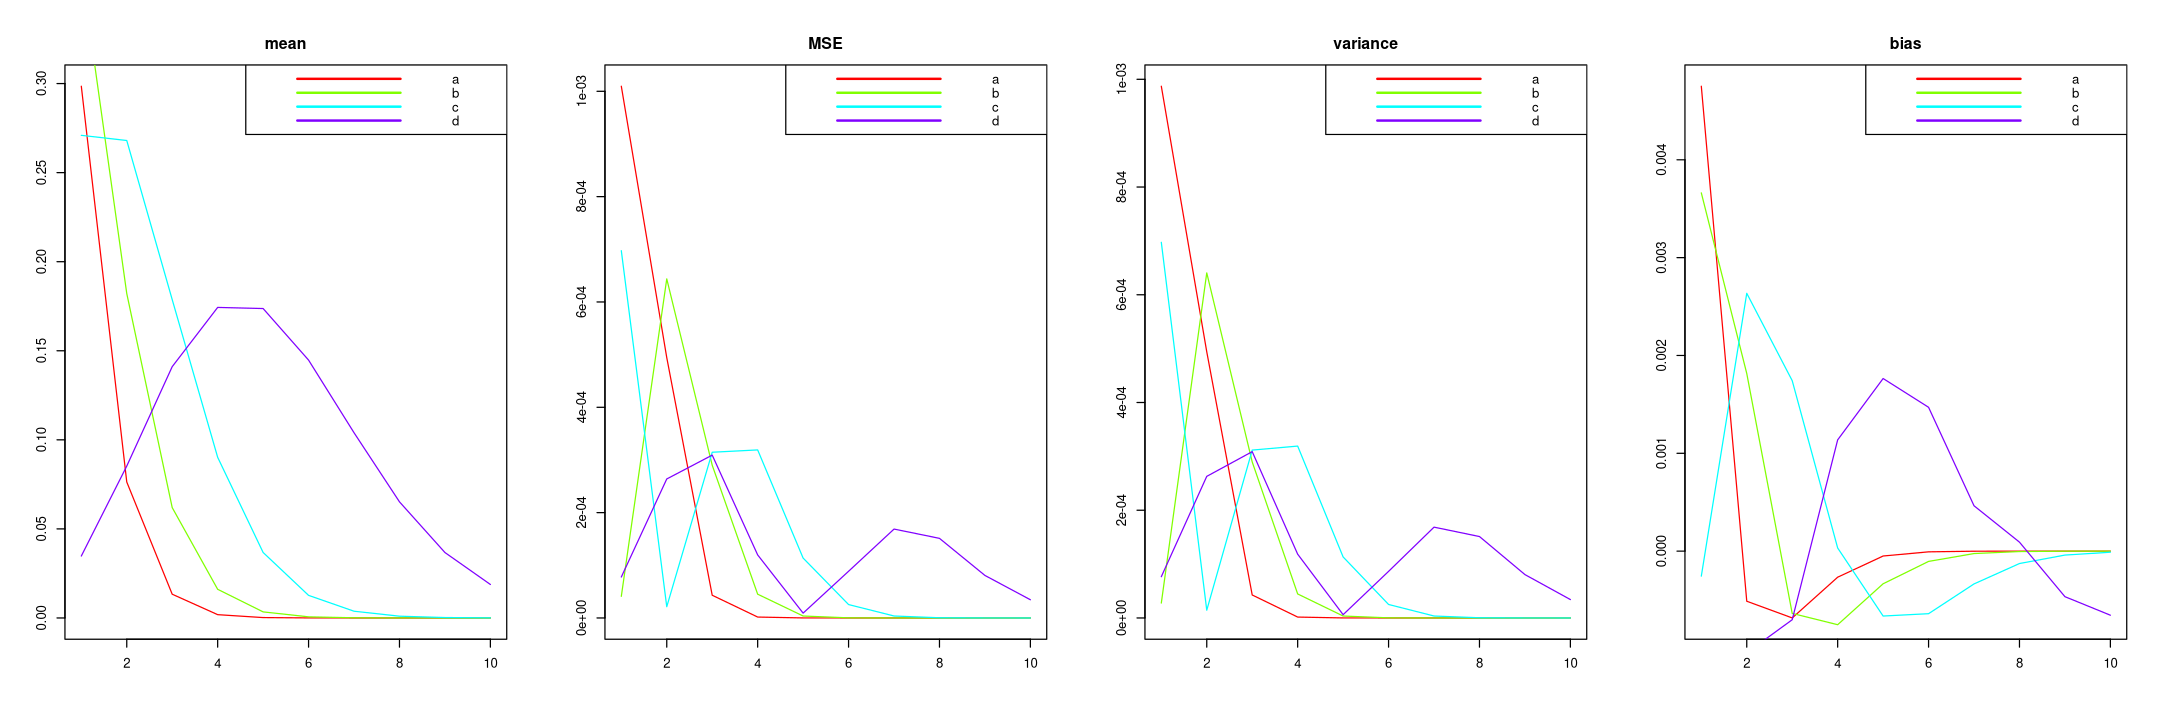

In [24]:
ex2(n = 20)

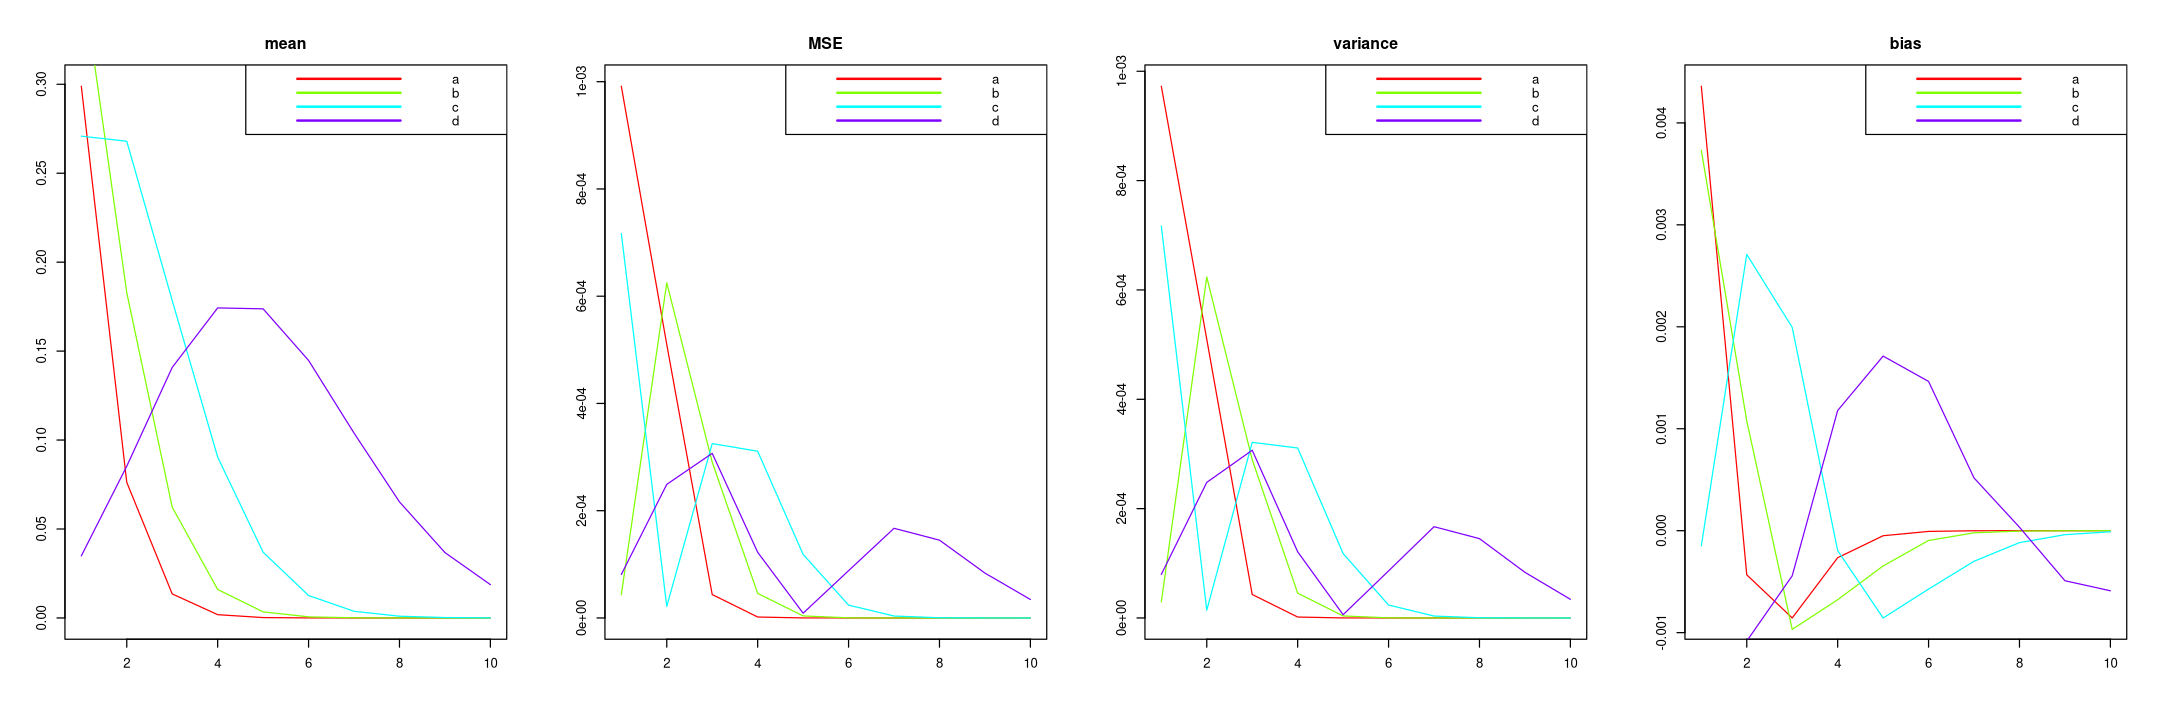

In [25]:
ex2(n = 50)

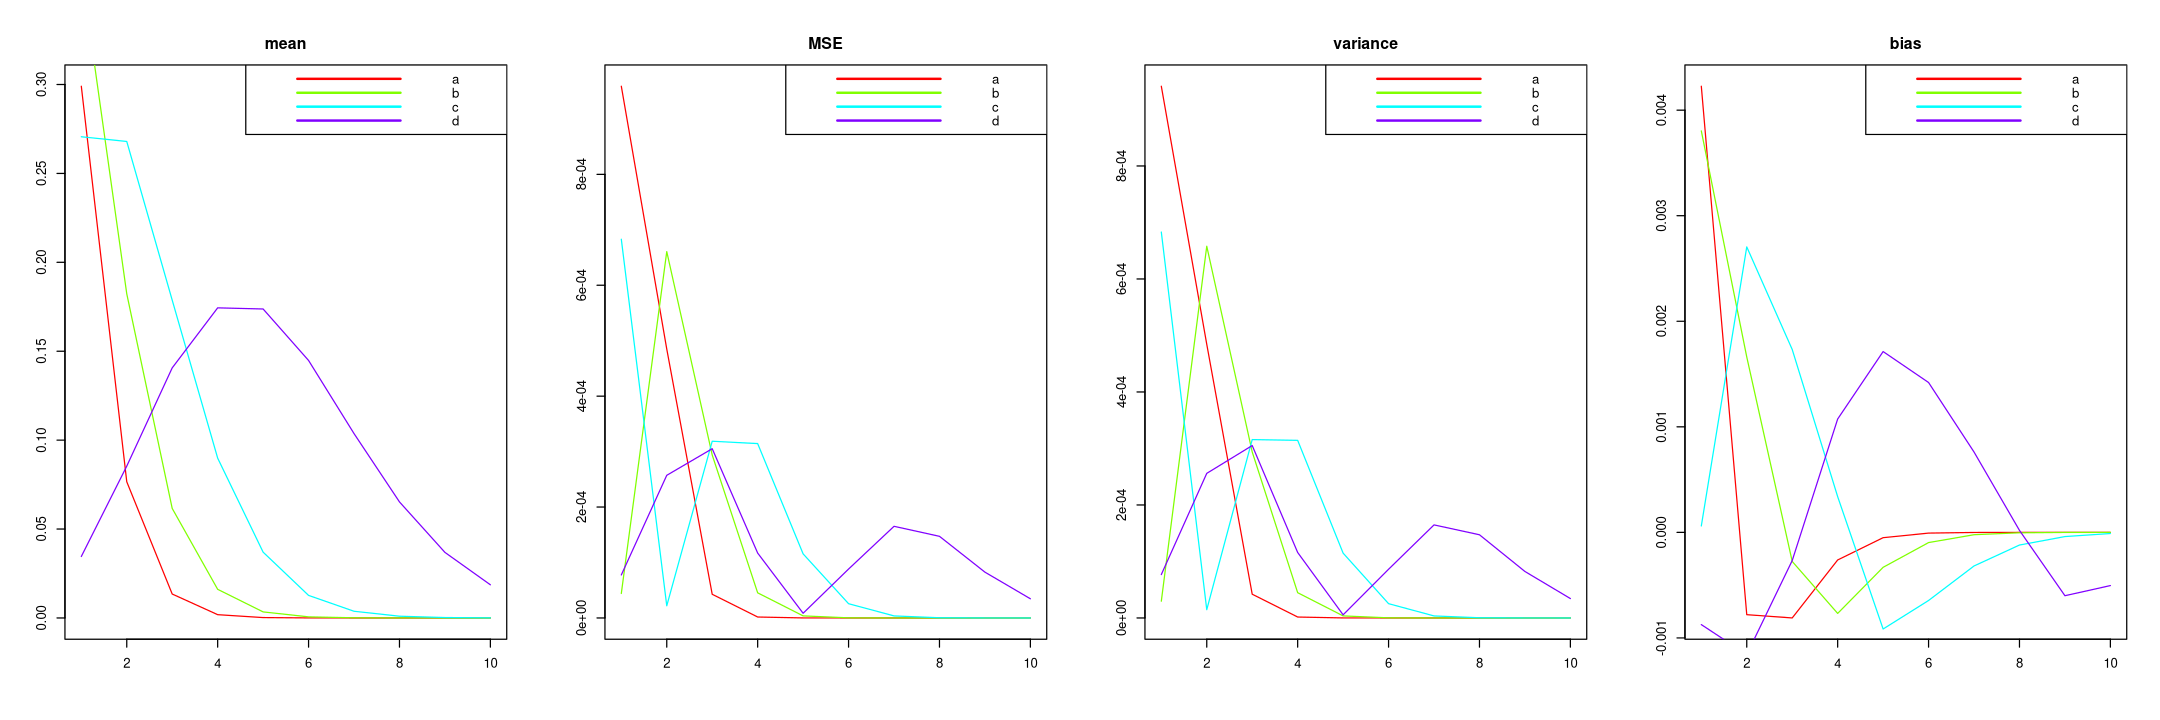

In [26]:
ex2(n = 100)

No apparent changes here.

### ex.3

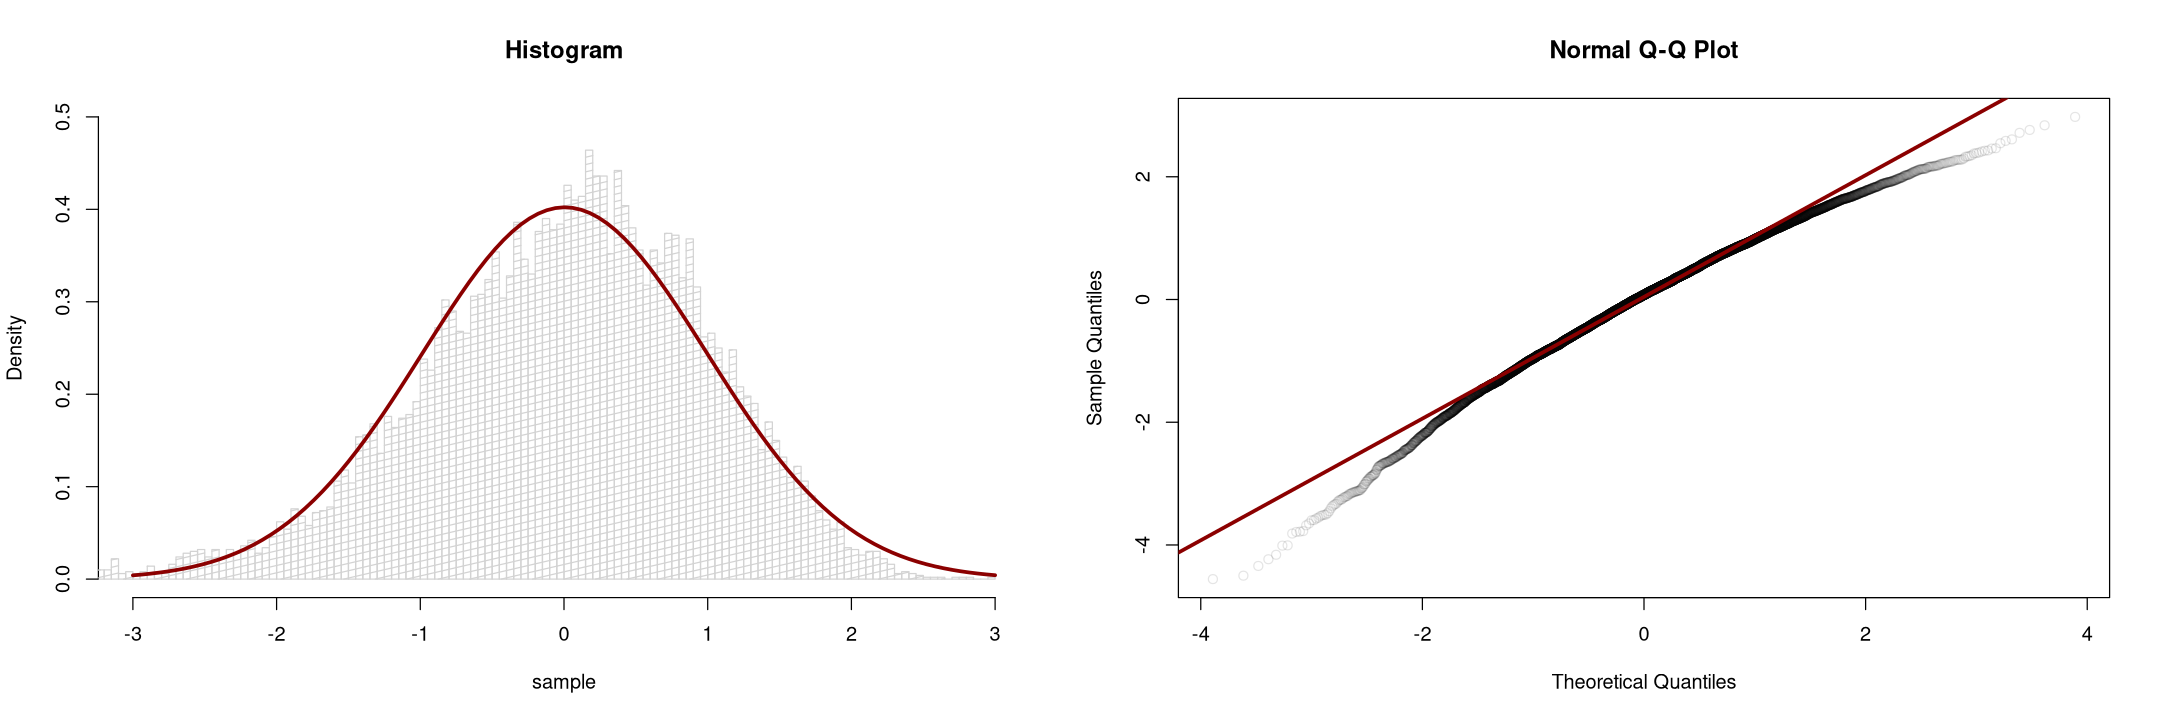

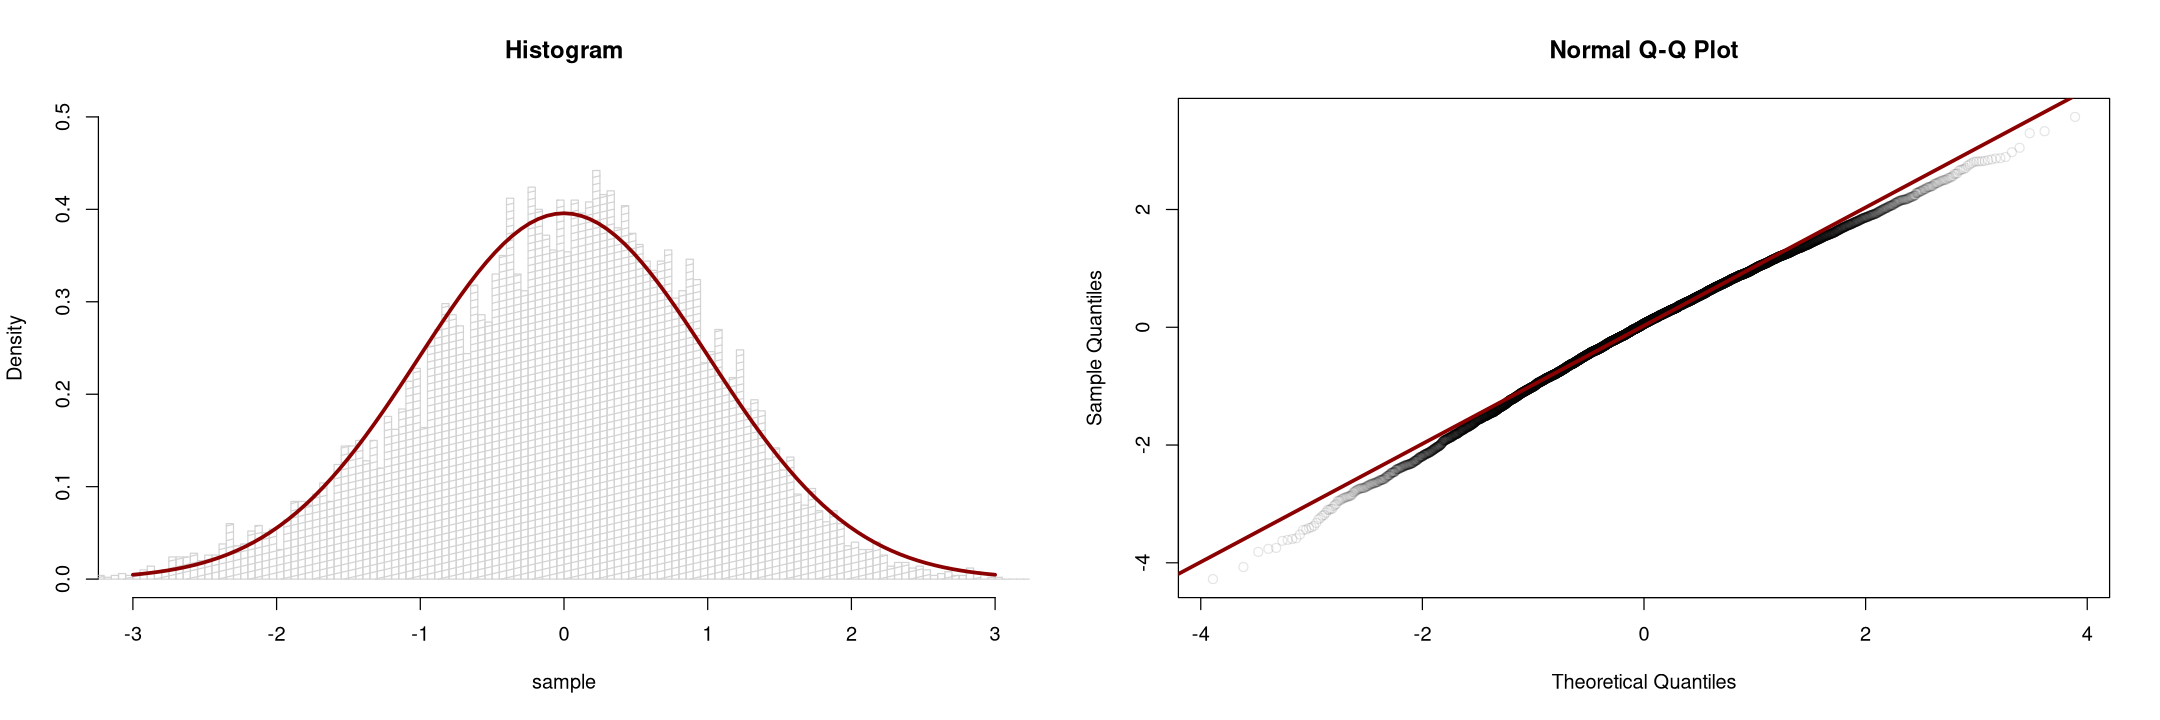

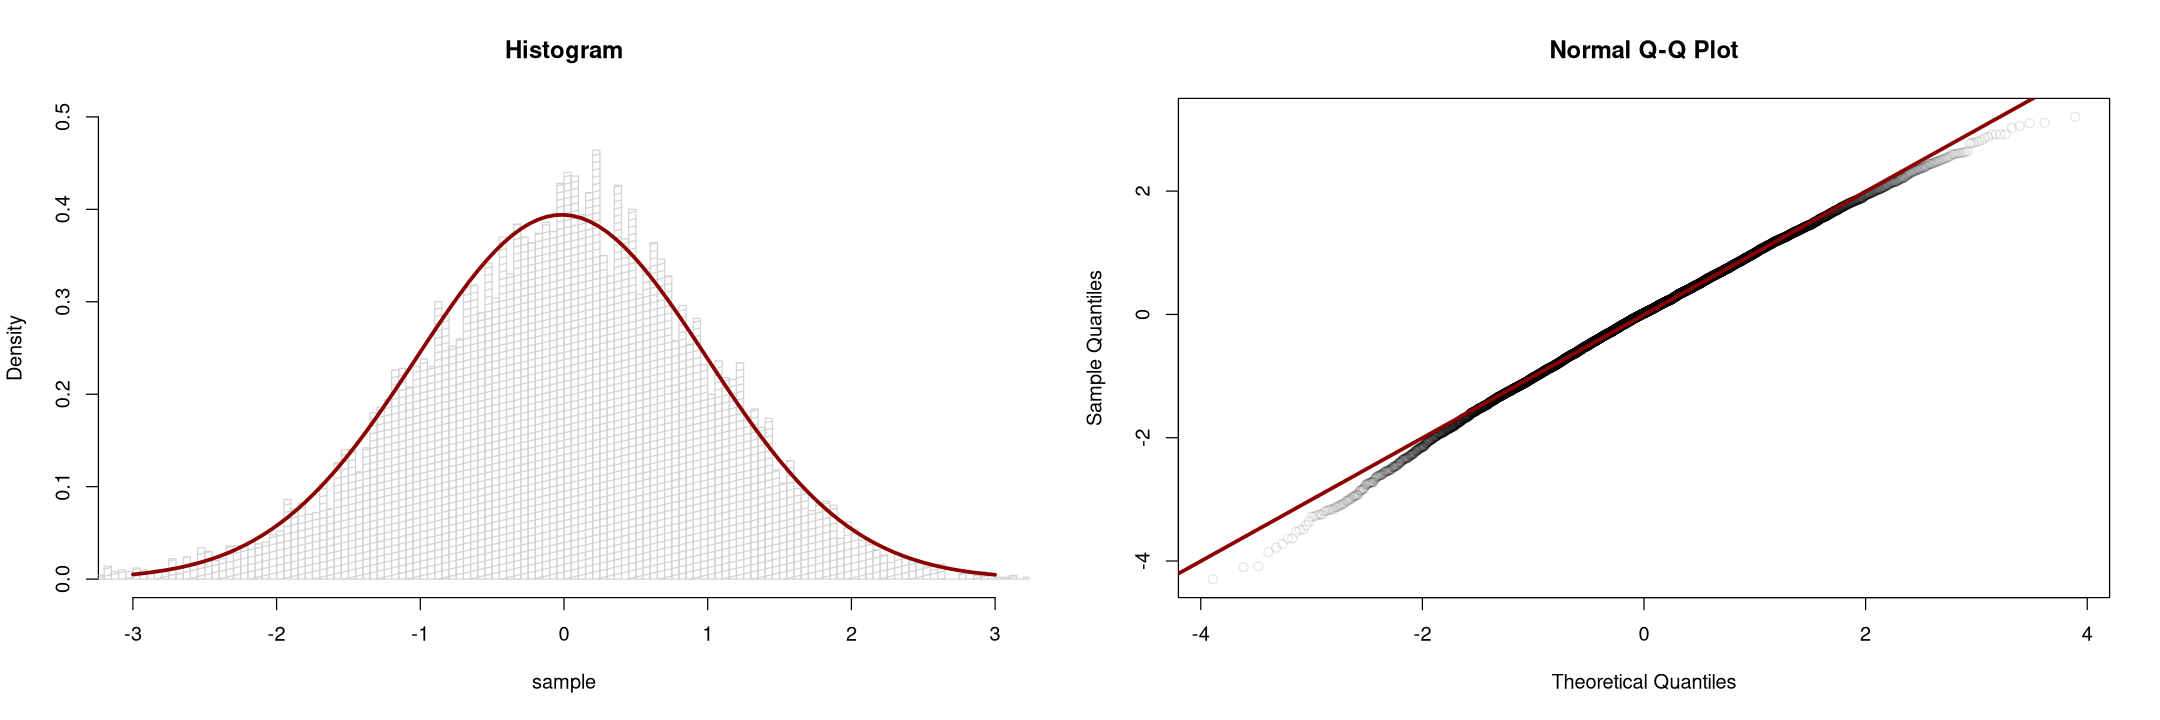

In [263]:
make.plots(estimate.y(θ = 0.5, n = 20))
make.plots(estimate.y(θ = 0.5, n = 50))
make.plots(estimate.y(θ = 0.5, n = 100))

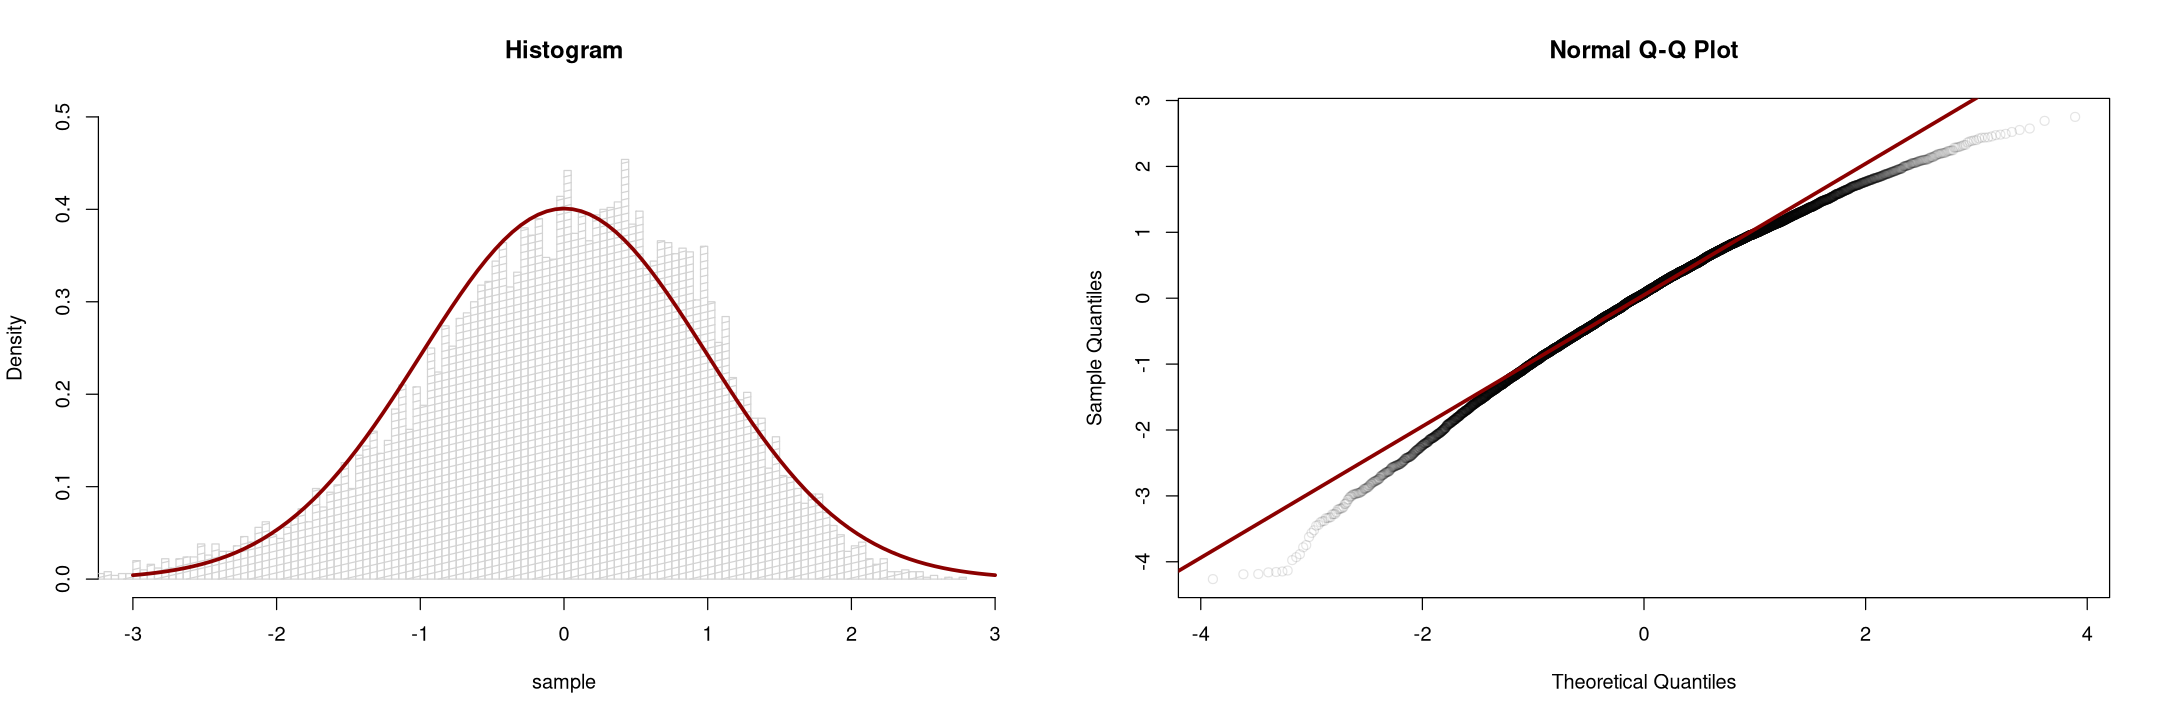

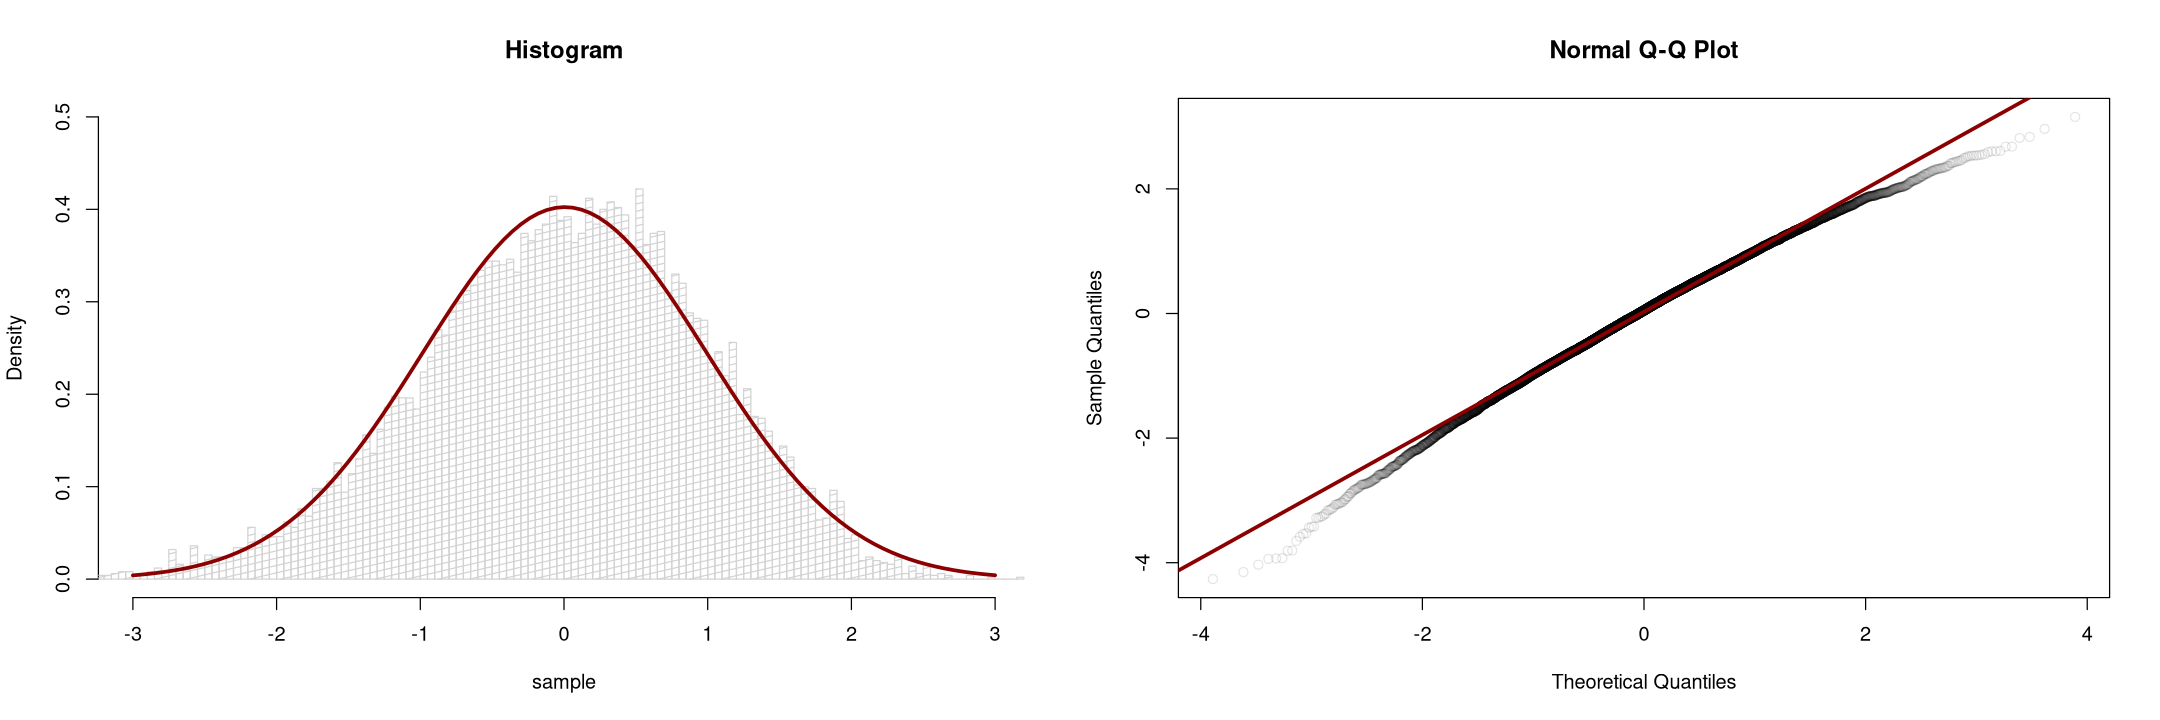

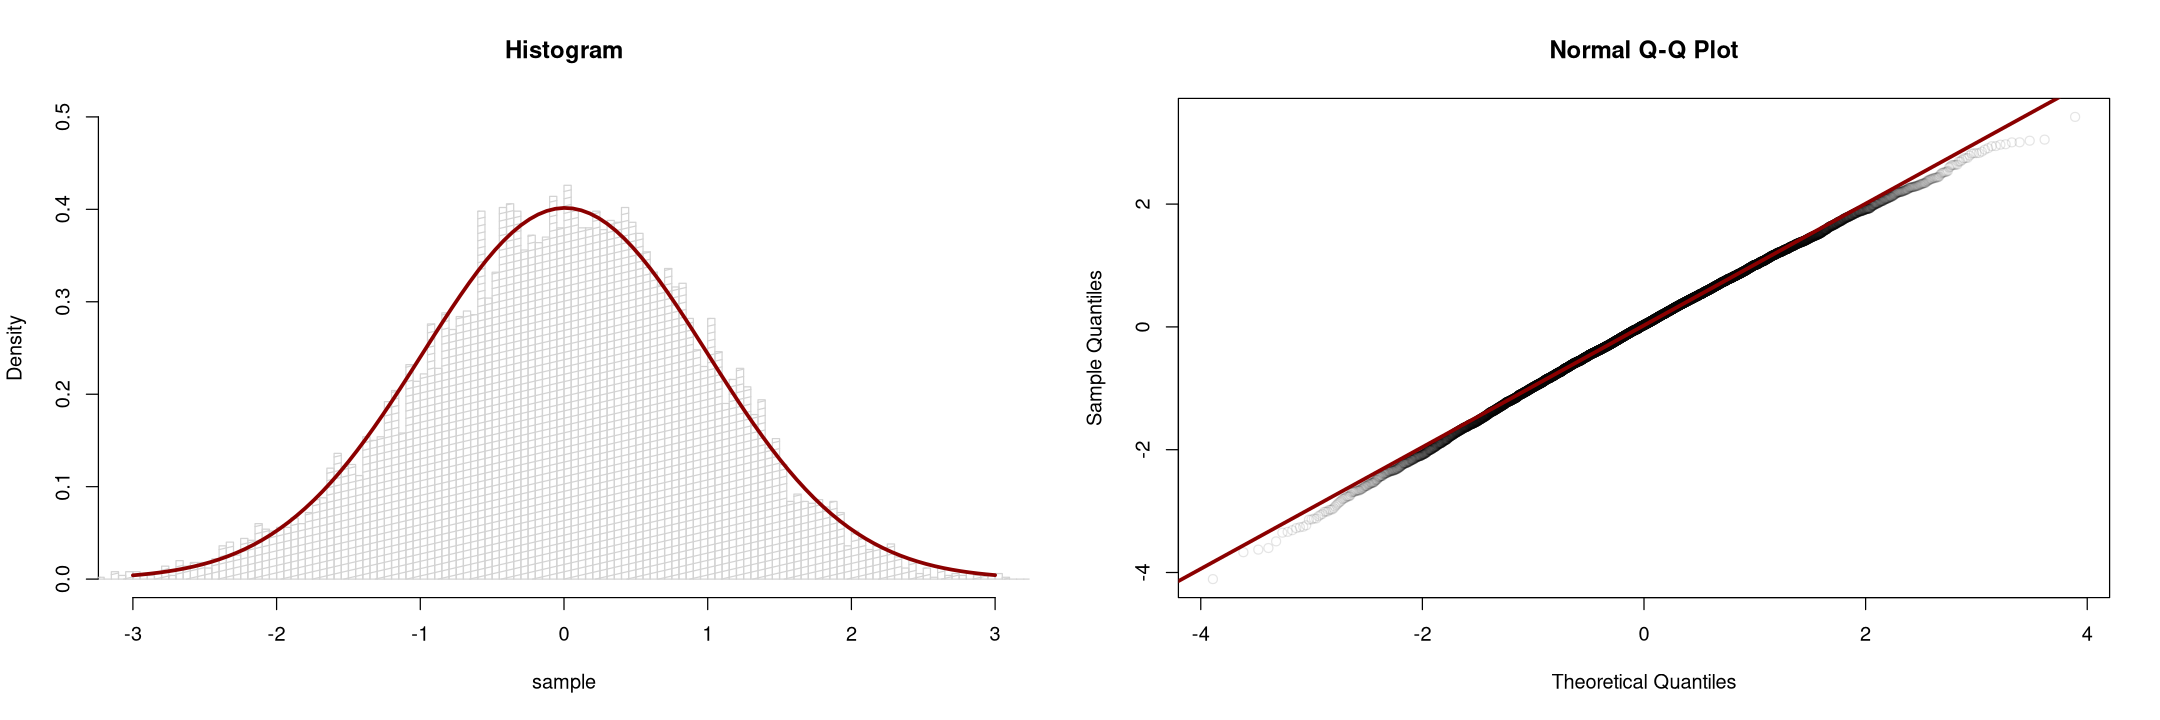

In [262]:
make.plots(estimate.y(θ = 1, n = 20))
make.plots(estimate.y(θ = 1, n = 50))
make.plots(estimate.y(θ = 1, n = 100))

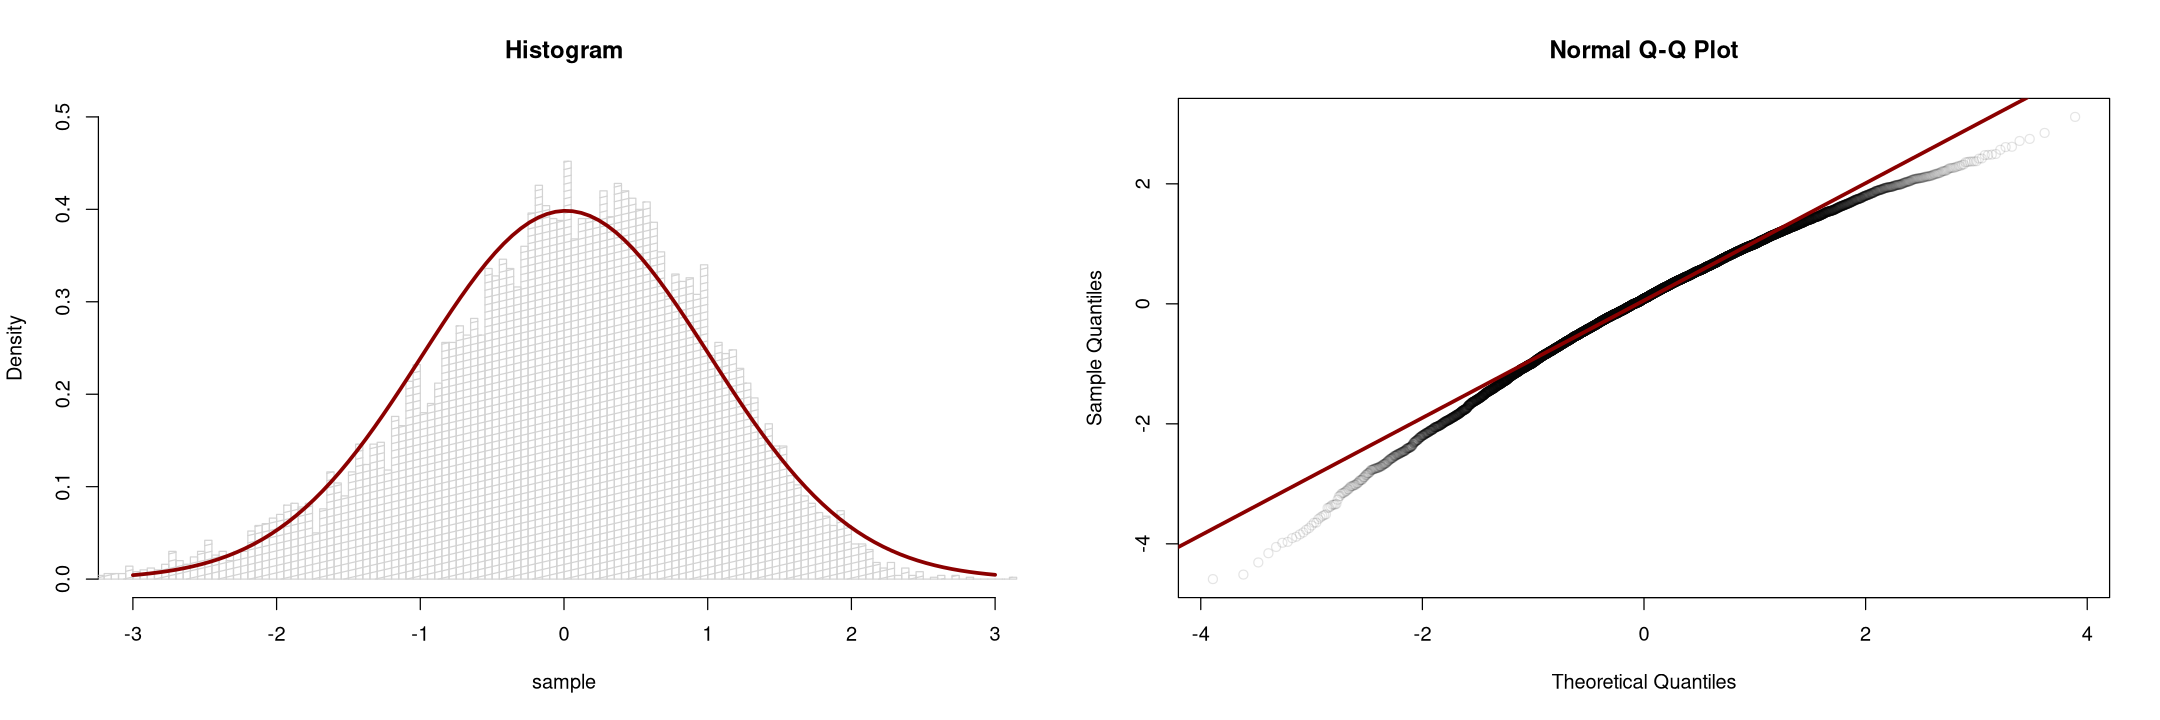

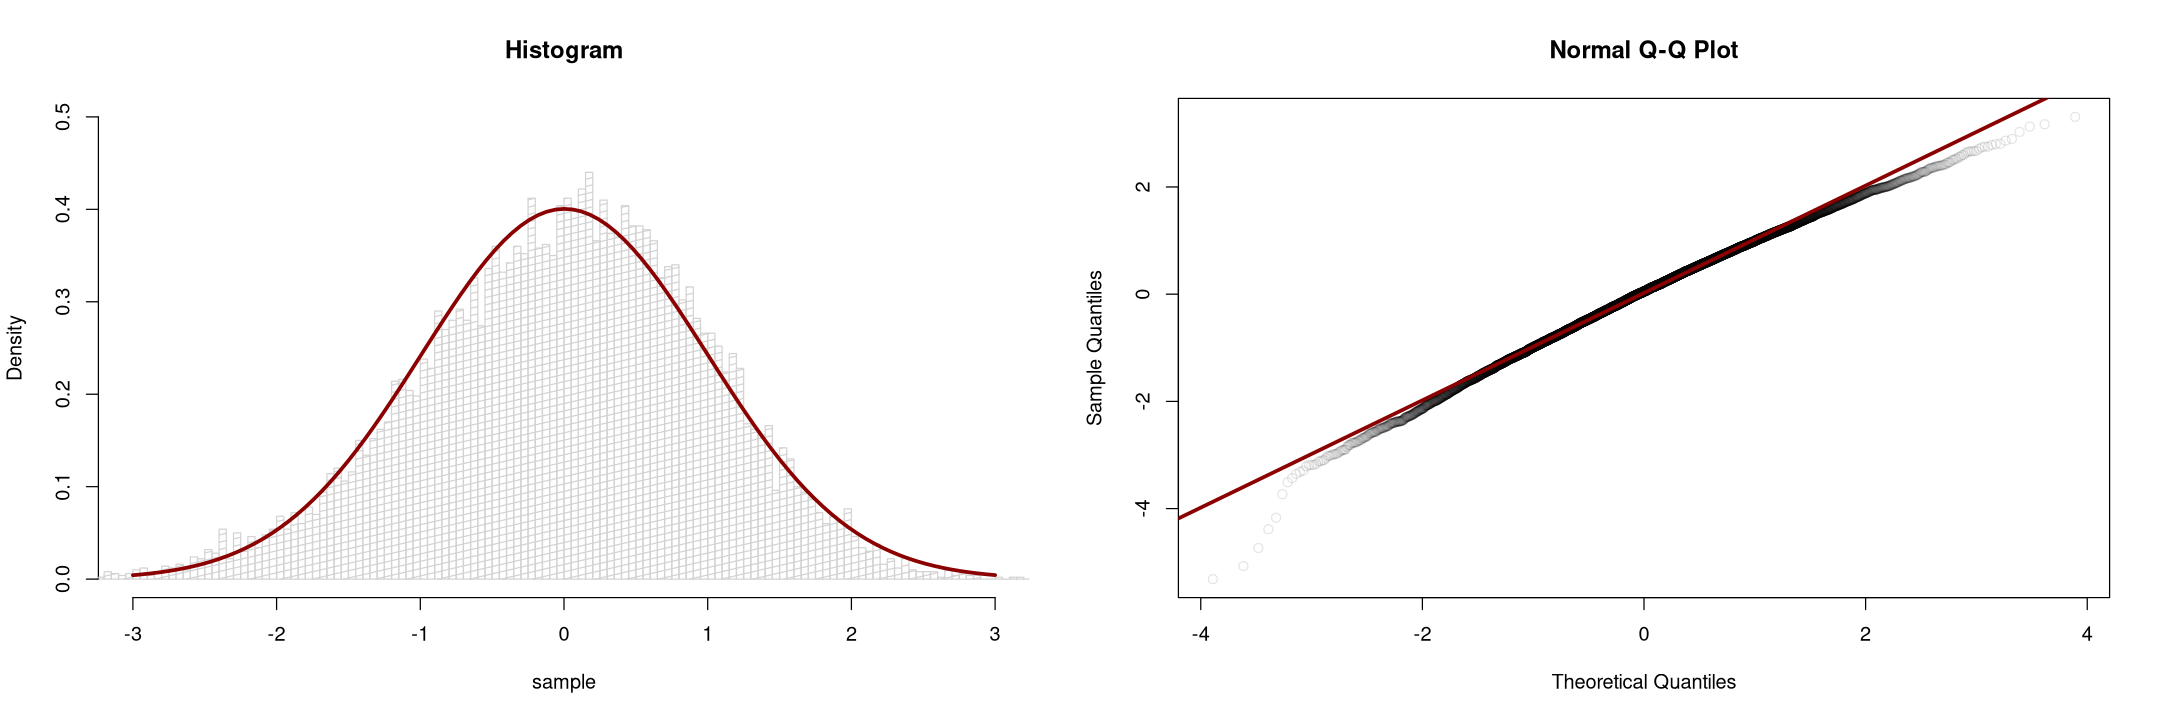

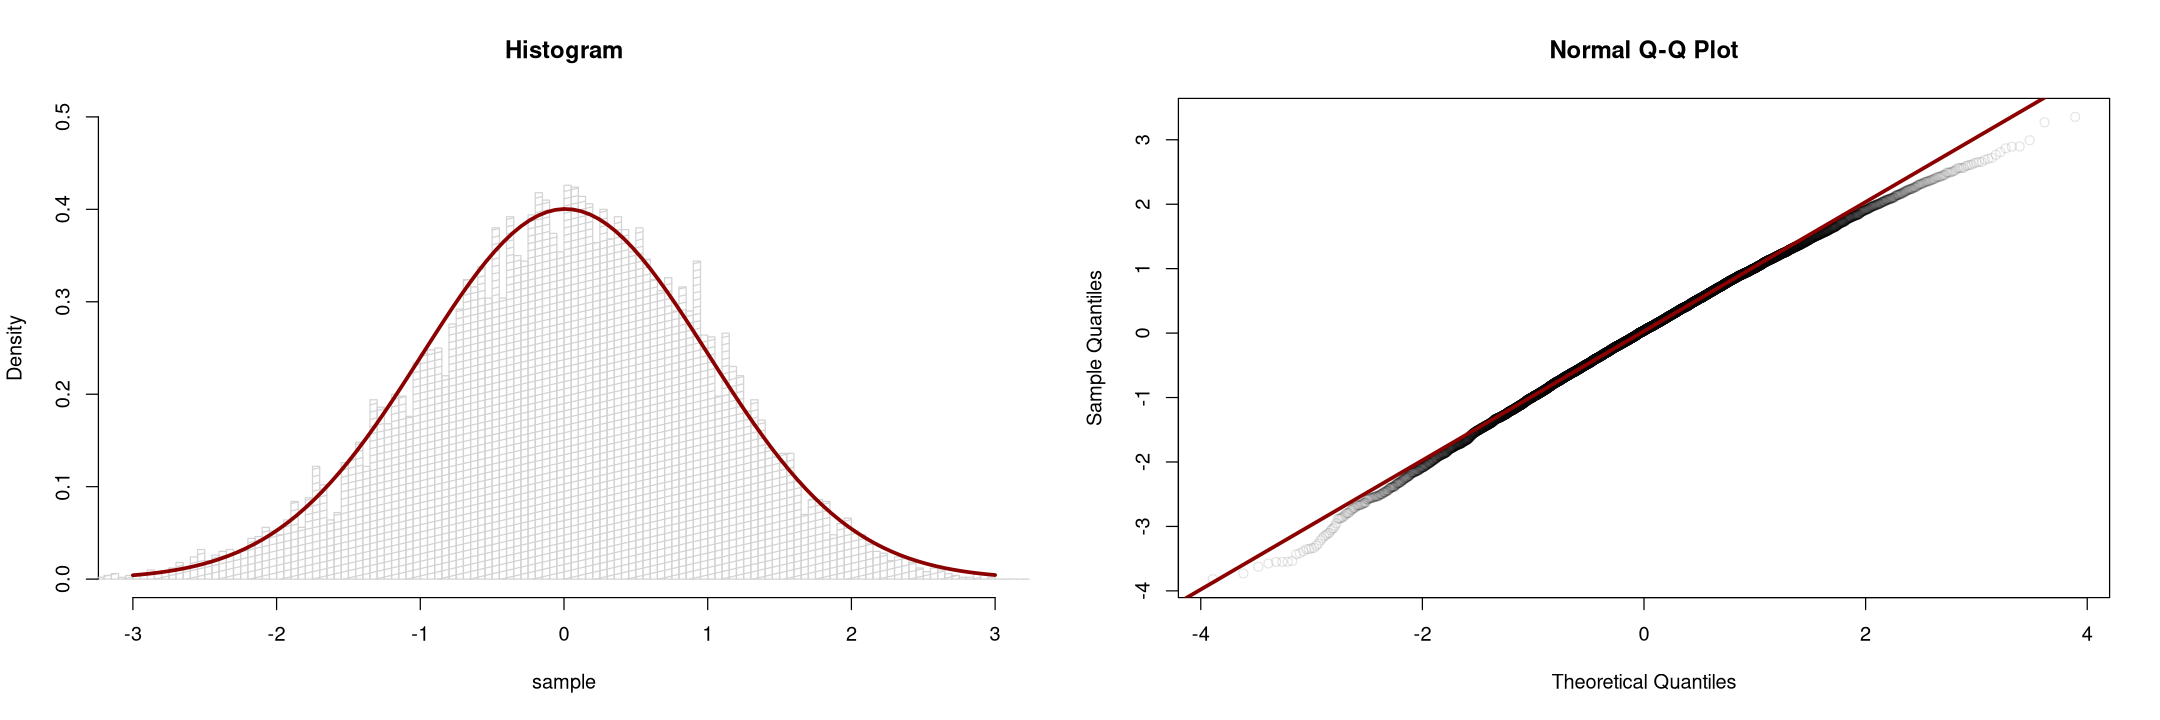

In [264]:
make.plots(estimate.y(θ = 2, n = 20))
make.plots(estimate.y(θ = 2, n = 50))
make.plots(estimate.y(θ = 2, n = 100))

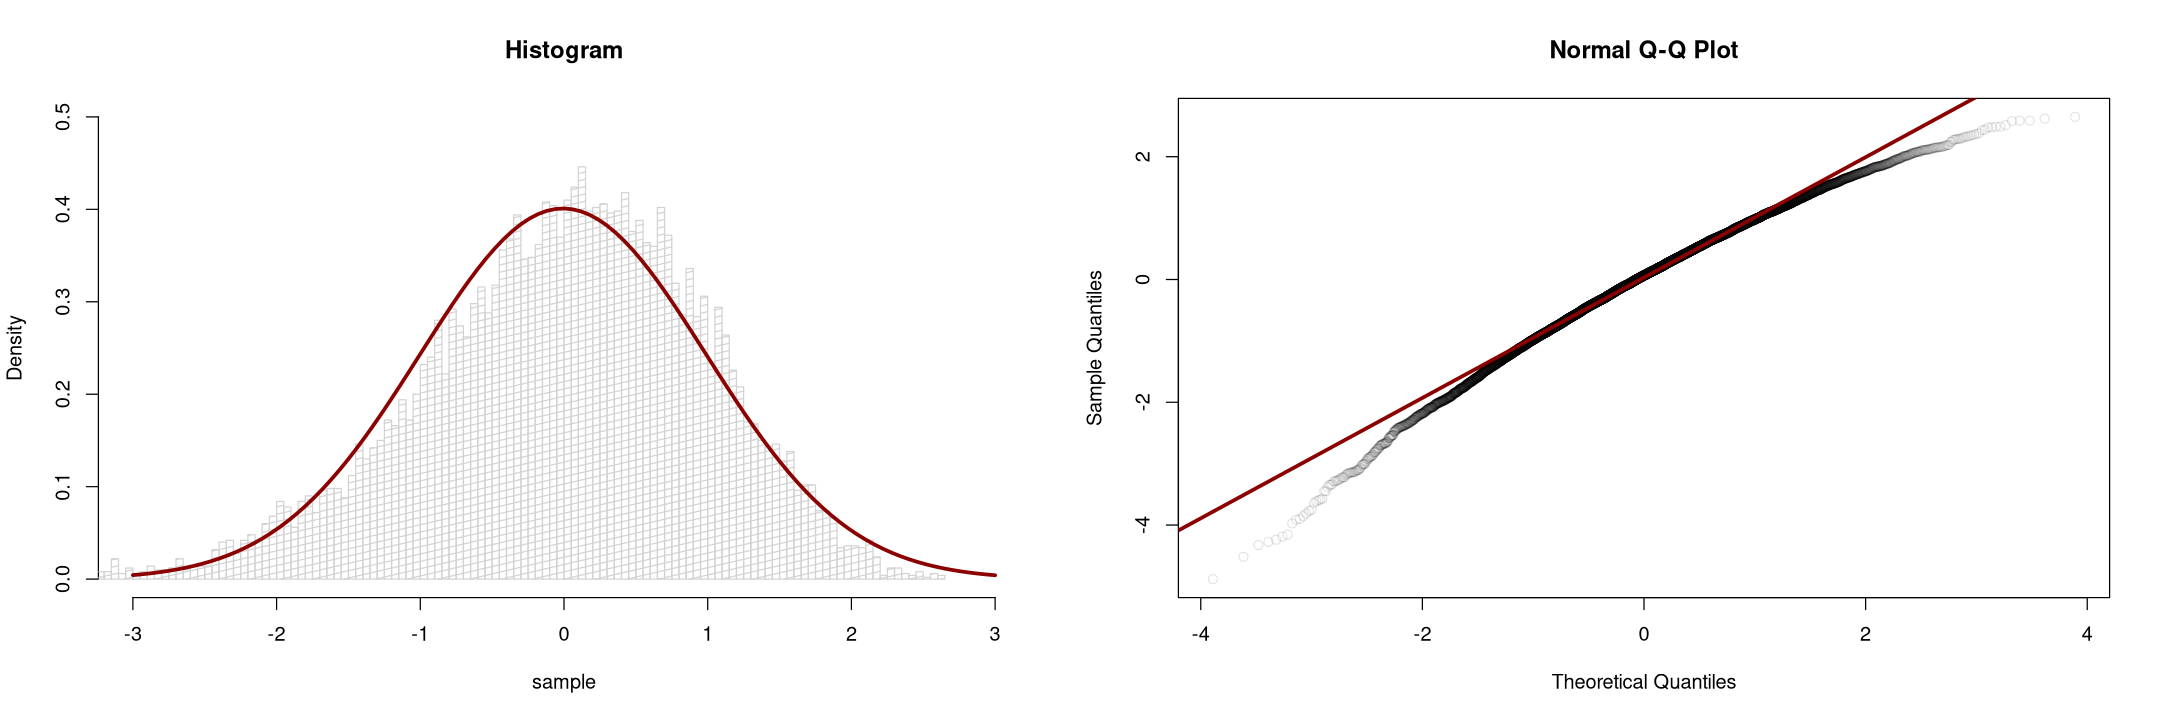

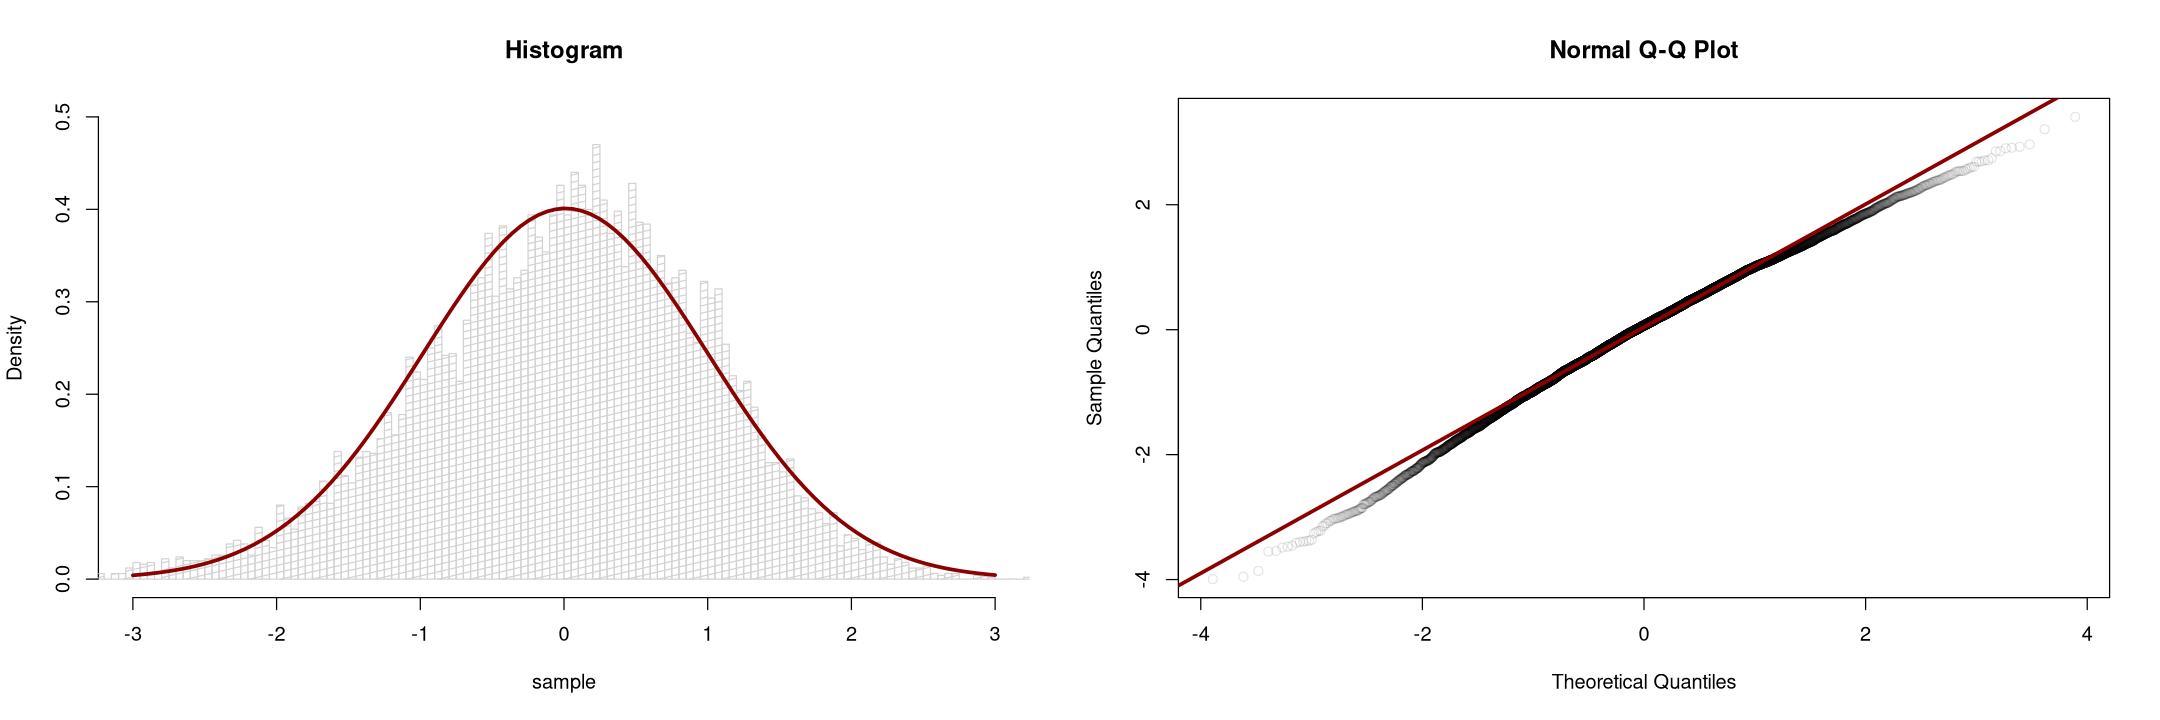

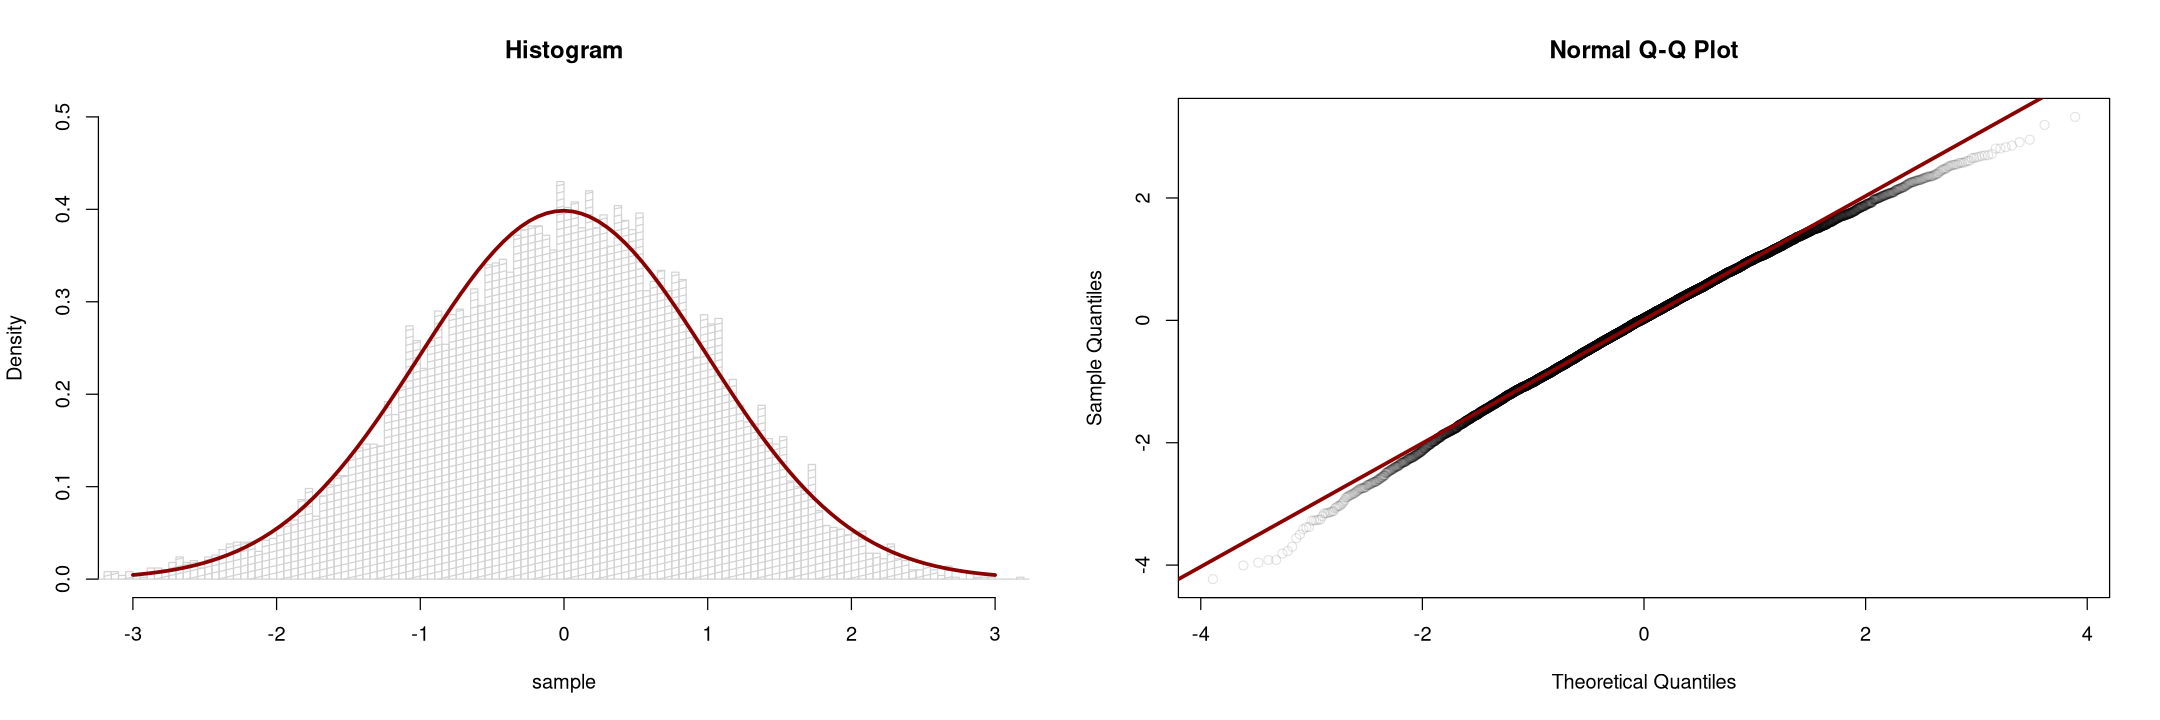

In [265]:
make.plots(estimate.y(θ = 5, n = 20))
make.plots(estimate.y(θ = 5, n = 50))
make.plots(estimate.y(θ = 5, n = 100))

Not much to be said here apart maybe from the observation that the distribution gets closer to normal with the increase of sample size.

### ex.4

#### Mean

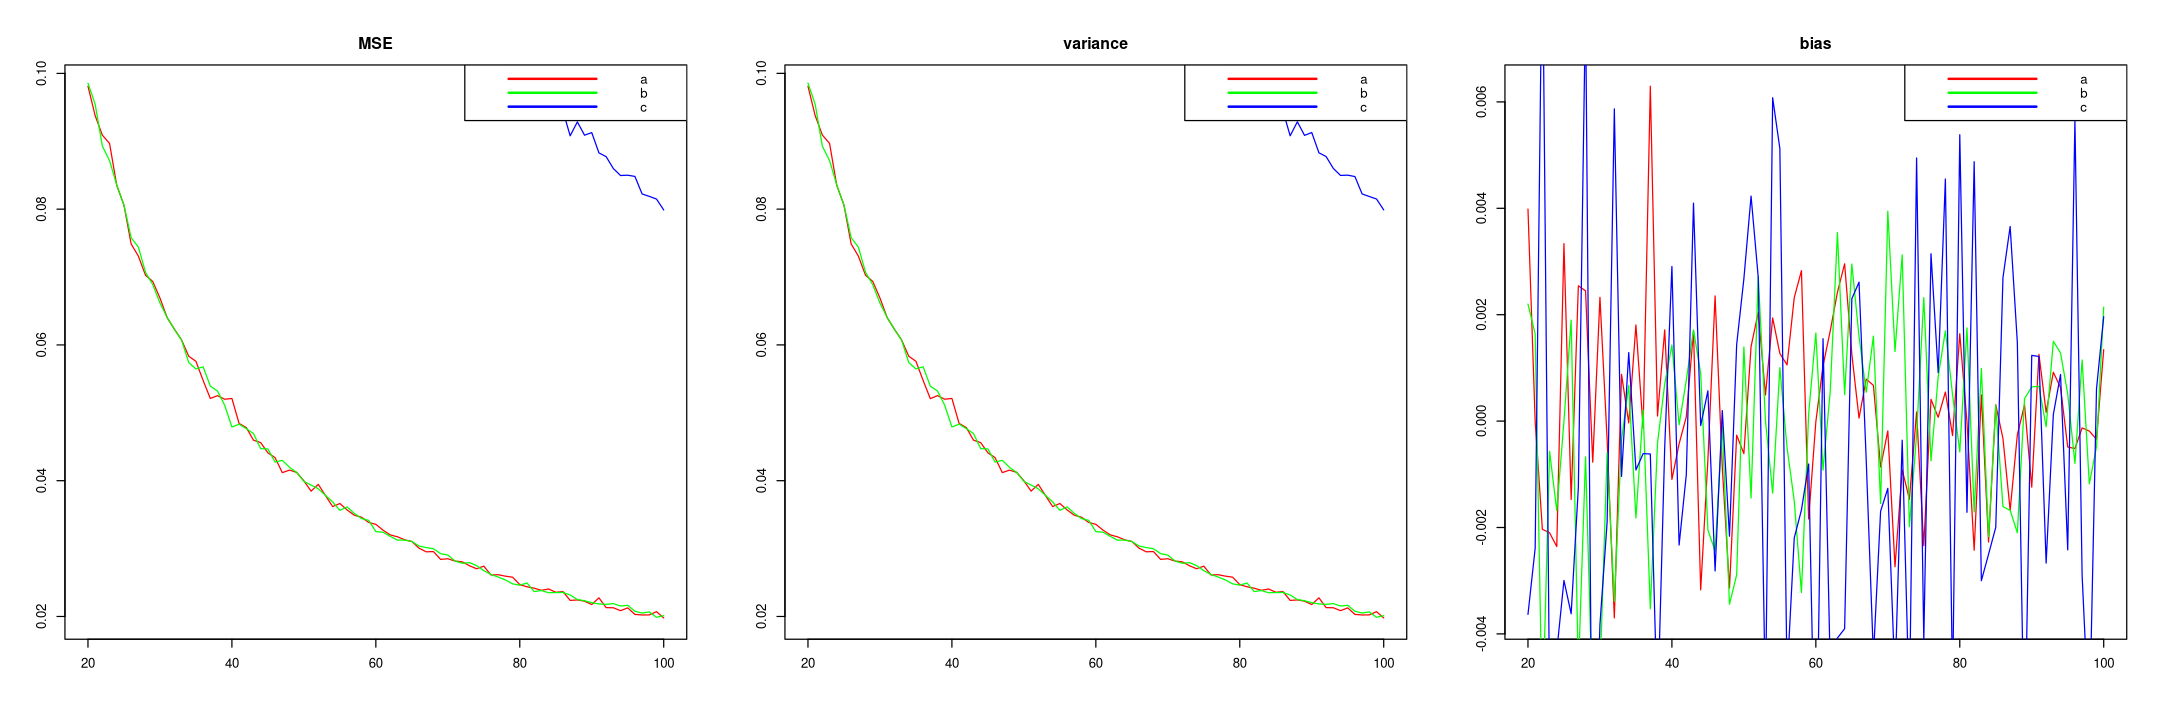

In [267]:
a = series(m = 1, s = 1, distribution = rlaplace, estimator = mean)
b = series(m = 4, s = 1, distribution = rlaplace, estimator = mean)
c = series(m = 1, s = 2, distribution = rlaplace, estimator = mean)
series.plot(a, b, c)

#### Median

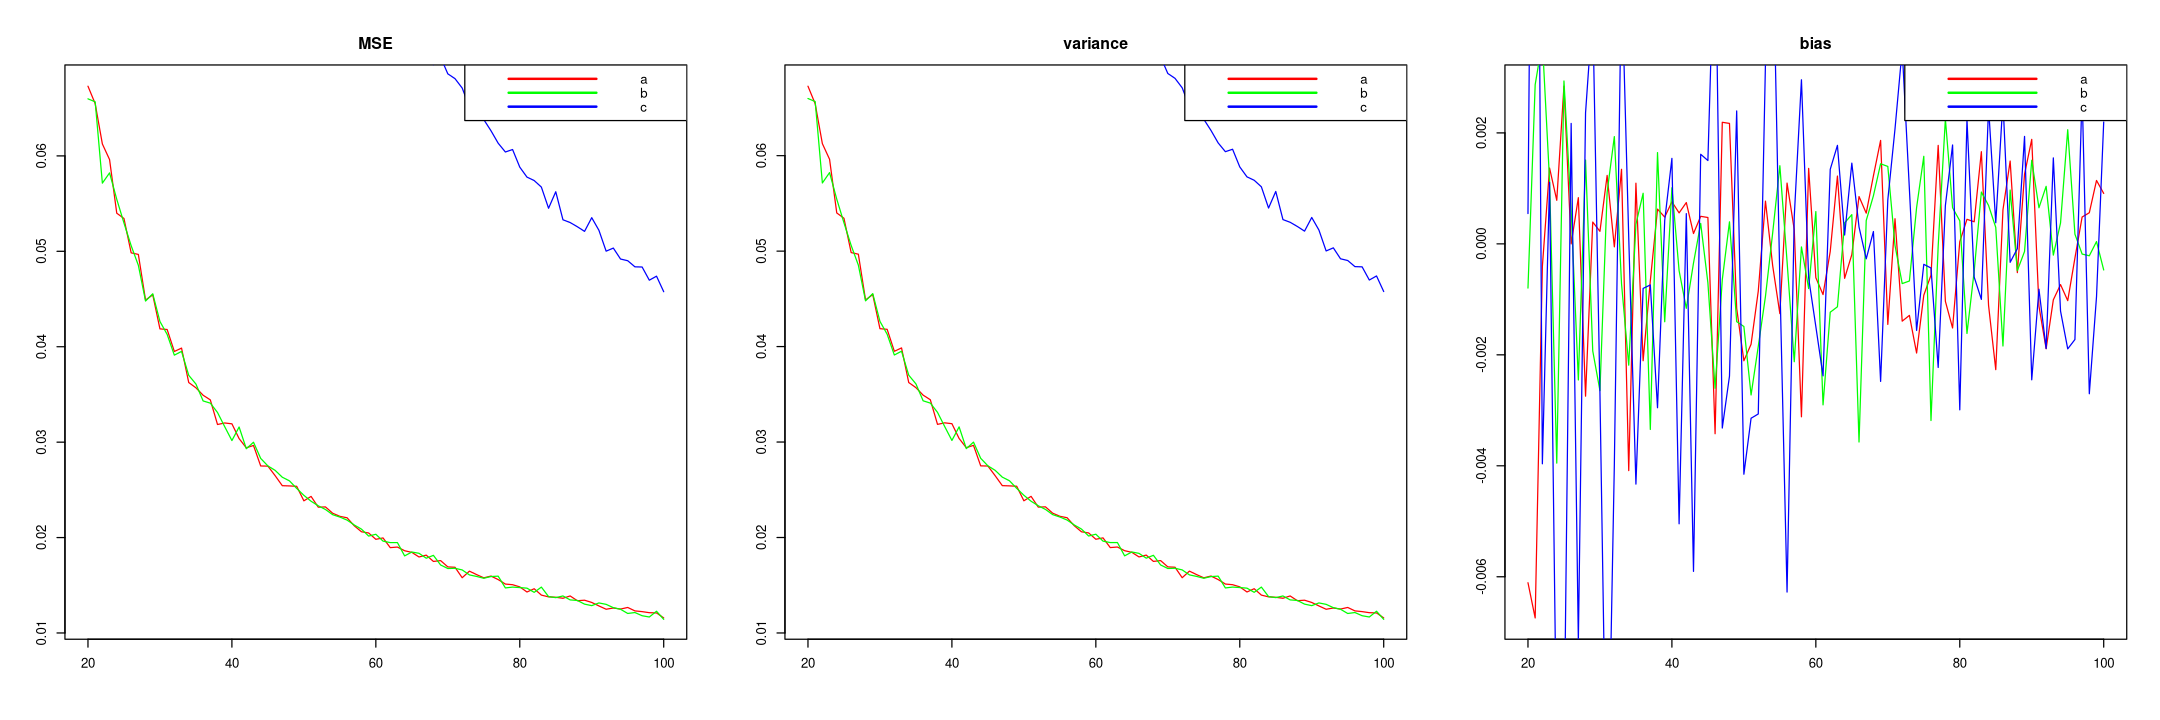

In [268]:
a = series(m = 1, s = 1, distribution = rlaplace, estimator = median)
b = series(m = 4, s = 1, distribution = rlaplace, estimator = median)
c = series(m = 1, s = 2, distribution = rlaplace, estimator = median)
series.plot(a, b, c)

#### Randomized weighted sum

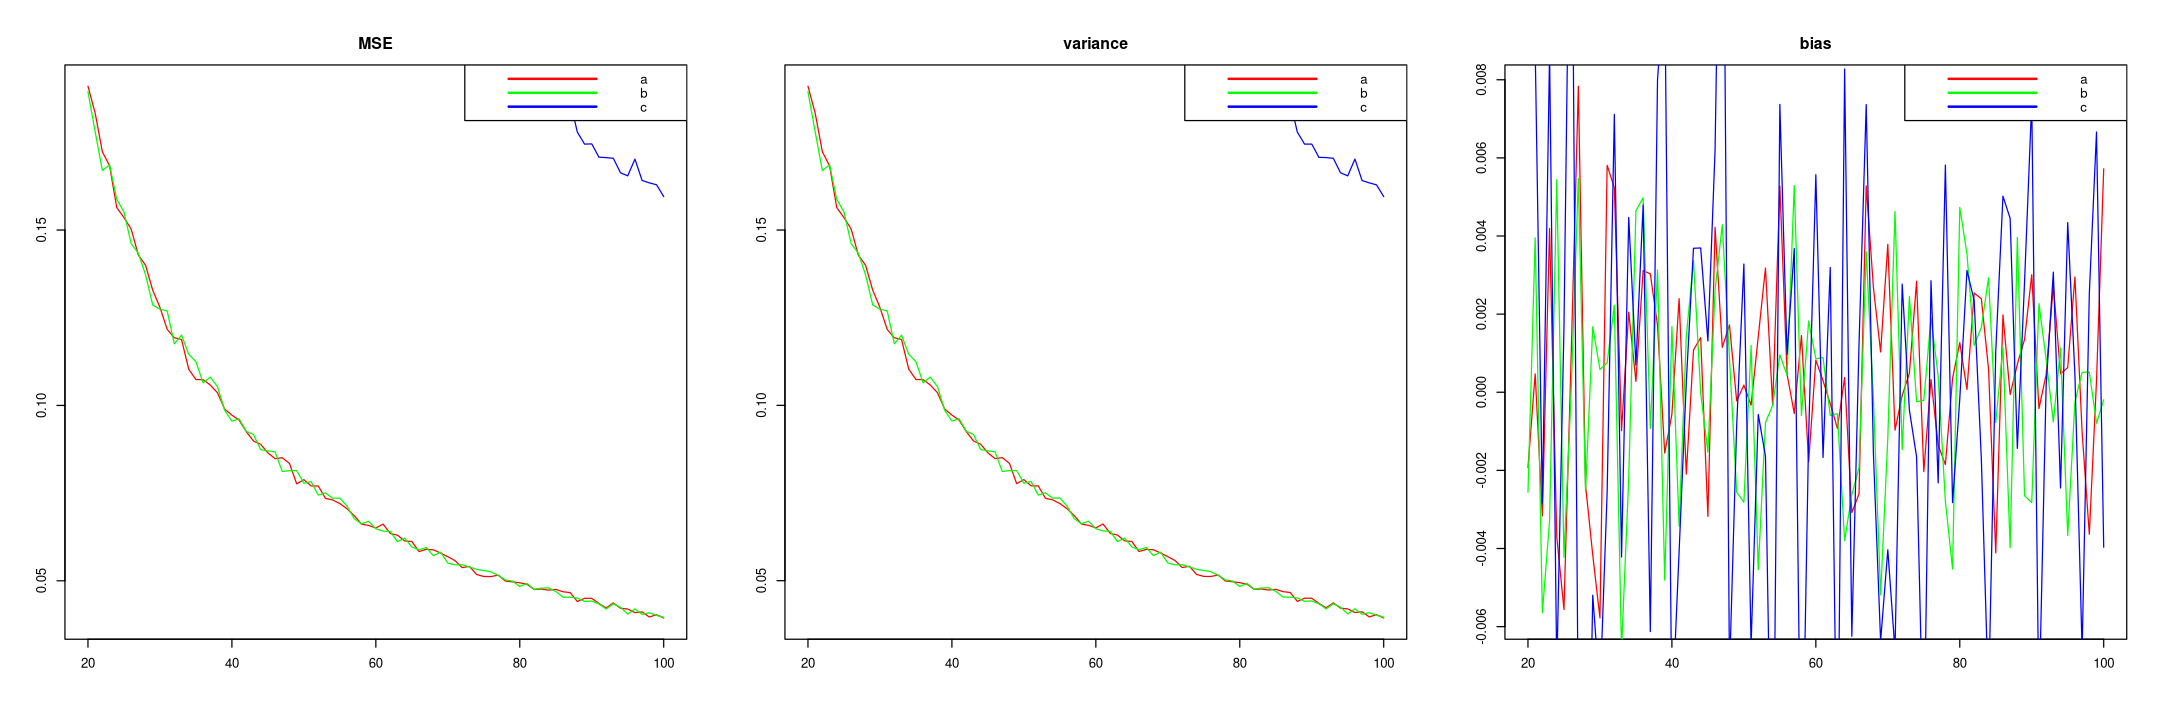

In [269]:
a = series(m = 1, s = 1, distribution = rlaplace, estimator = randomized_weight_sum)
b = series(m = 4, s = 1, distribution = rlaplace, estimator = randomized_weight_sum)
c = series(m = 1, s = 2, distribution = rlaplace, estimator = randomized_weight_sum)
series.plot(a, b, c)

#### Specific weighted sum

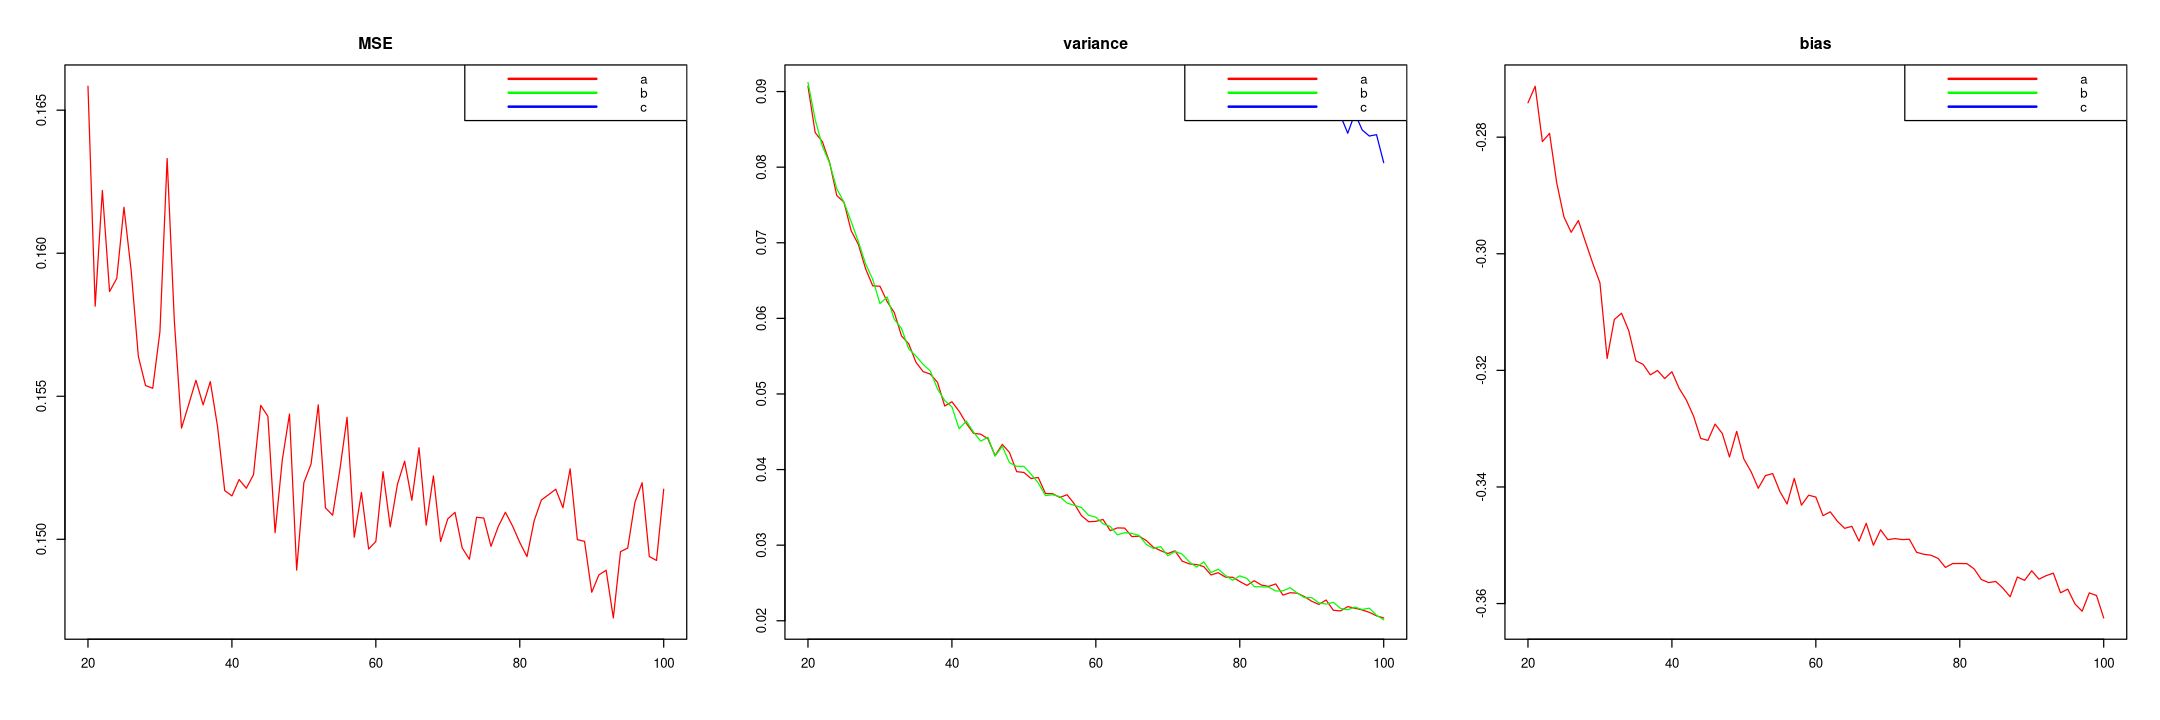

In [270]:
a = series(m = 1, s = 1, distribution = rlaplace, estimator = wi_weight_sum)
b = series(m = 4, s = 1, distribution = rlaplace, estimator = wi_weight_sum)
c = series(m = 1, s = 2, distribution = rlaplace, estimator = wi_weight_sum)
series.plot(a, b, c)